In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('../data/sales_train_evaluation.csv')
sub_data = pd.read_csv('../data/sample_submission.csv')
sales_prices = pd.read_csv('../data/sell_prices.csv')
calendar = pd.read_csv('../data/calendar.csv')

In [4]:
sales_prices

store_id        item_id  wm_yr_wk  sell_price
0           CA_1  HOBBIES_1_001     11325        9.58
1           CA_1  HOBBIES_1_001     11326        9.58
2           CA_1  HOBBIES_1_001     11327        8.26
3           CA_1  HOBBIES_1_001     11328        8.26
4           CA_1  HOBBIES_1_001     11329        8.26
...          ...            ...       ...         ...
6841116     WI_3    FOODS_3_827     11617        1.00
6841117     WI_3    FOODS_3_827     11618        1.00
6841118     WI_3    FOODS_3_827     11619        1.00
6841119     WI_3    FOODS_3_827     11620        1.00
6841120     WI_3    FOODS_3_827     11621        1.00

[6841121 rows x 4 columns]

In [335]:
len(train_data['store_id'].unique())

10

In [336]:
day_columns = [column for column in train_data.columns if 'd_' in column]

## All Items Analysis

In [337]:
all_sales = train_data[day_columns].sum()

In [338]:
all_sales = pd.DataFrame(all_sales, columns=['sales'])

In [339]:
all_sales

sales
d_1     32631
d_2     31749
d_3     23783
d_4     25412
d_5     19146
...       ...
d_1937  37096
d_1938  36963
d_1939  42552
d_1940  51518
d_1941  54338

[1941 rows x 1 columns]

### 趋势图

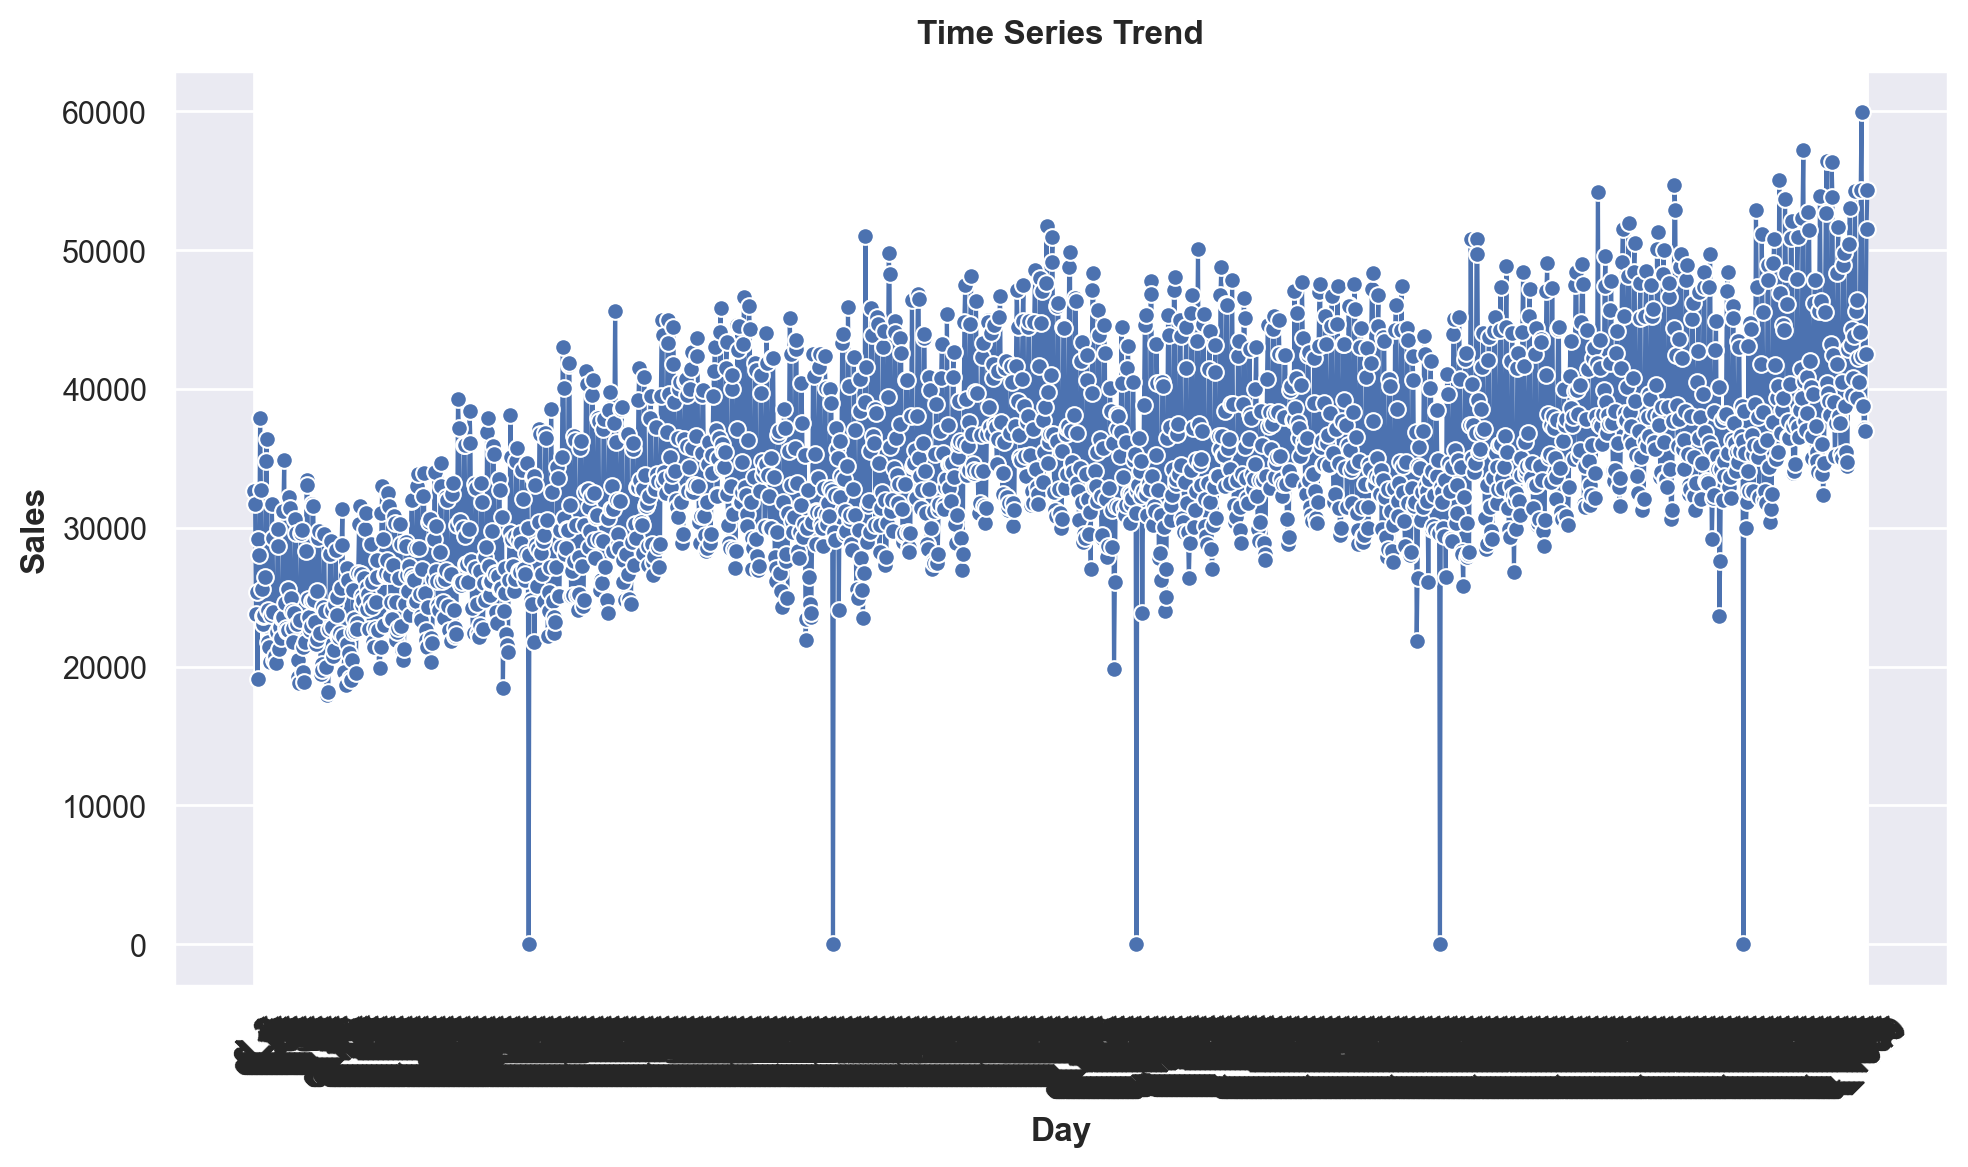

In [340]:
# 设置风格
sns.set(style="darkgrid")

# 绘制趋势图
plt.figure(figsize=(10, 6))
sns.lineplot(x=all_sales.index, y='sales', data=all_sales, marker='o')
plt.title('Time Series Trend')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.xticks(rotation=45)  # 旋转x轴标签
plt.show()

### 移动平均趋势图

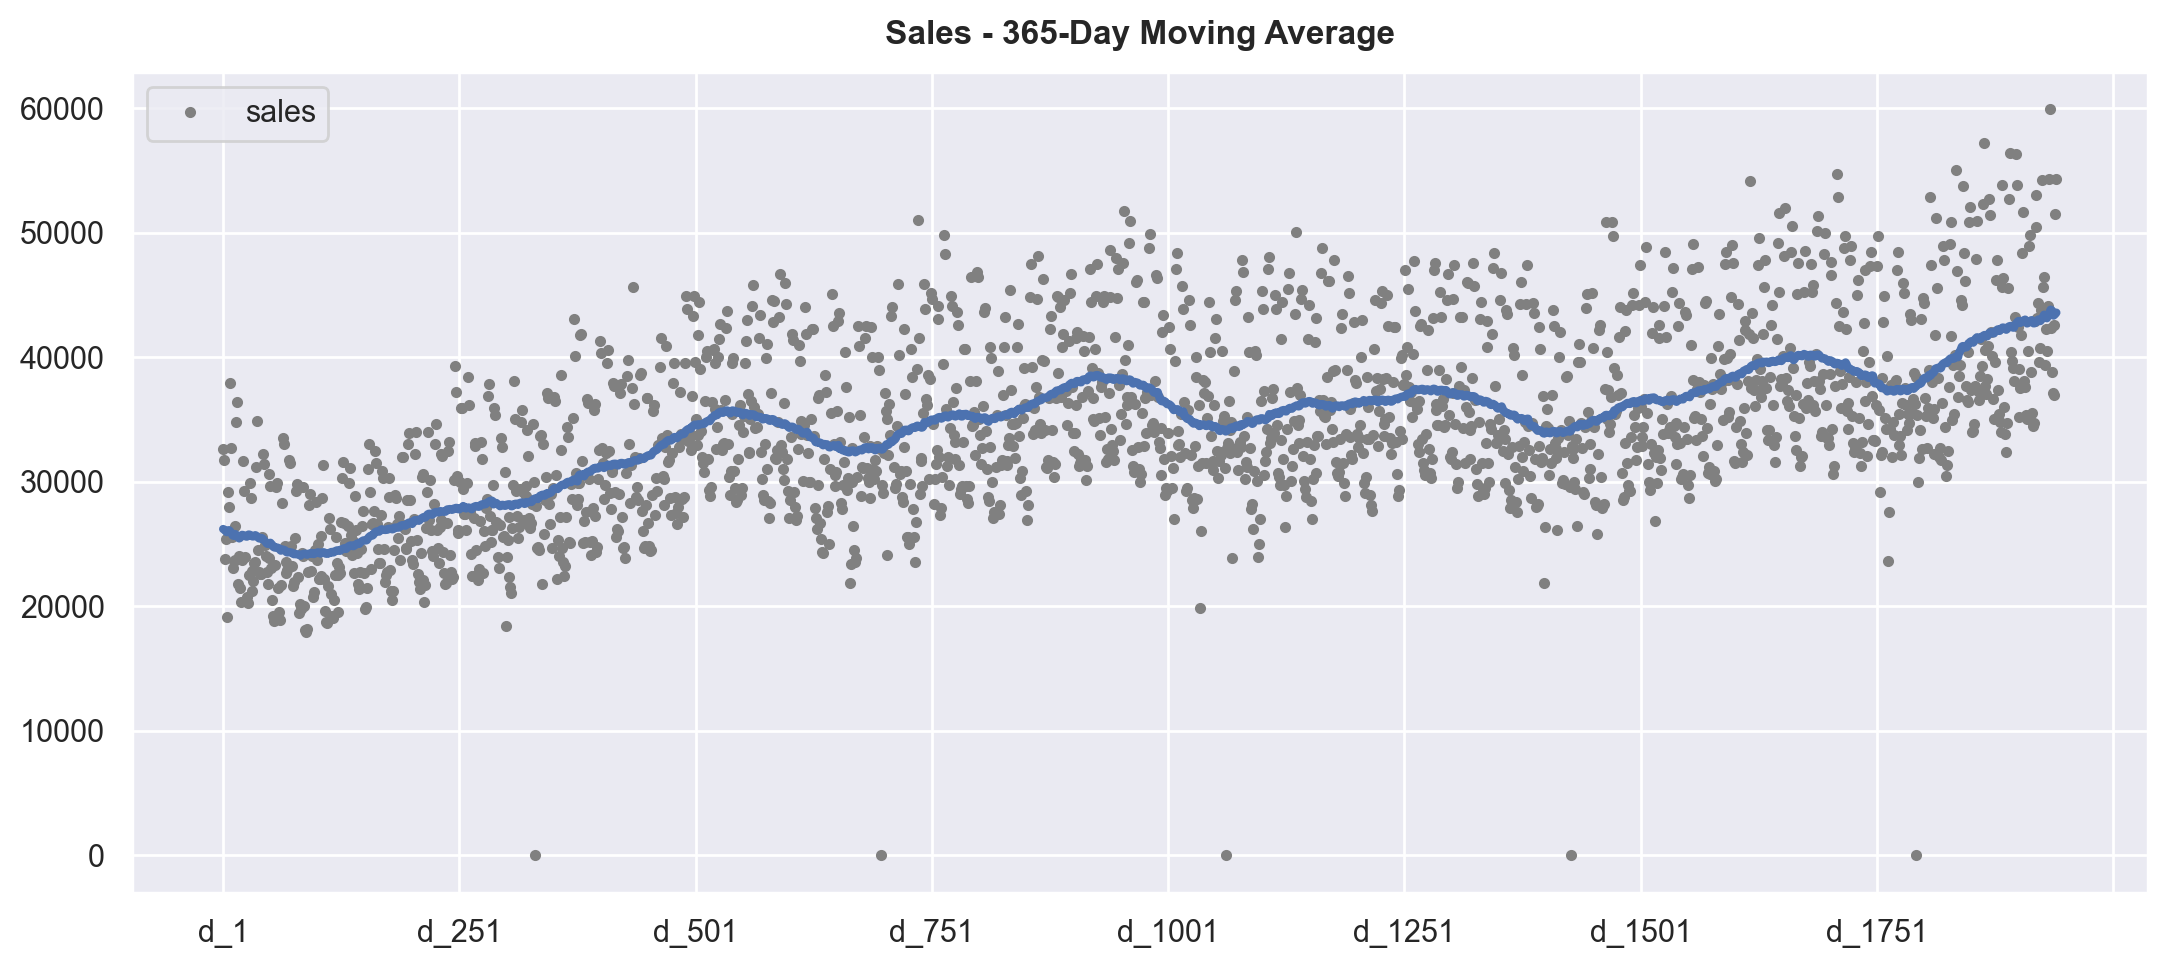

In [341]:
moving_average = all_sales.rolling(
    window=90,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=45,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = all_sales.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Sales - 365-Day Moving Average", legend=False,
);

### Trend

In [342]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=all_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

const  trend
d_1    1.0    1.0
d_2    1.0    2.0
d_3    1.0    3.0
d_4    1.0    4.0
d_5    1.0    5.0

In [343]:
from sklearn.linear_model import LinearRegression

y = all_sales["sales"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

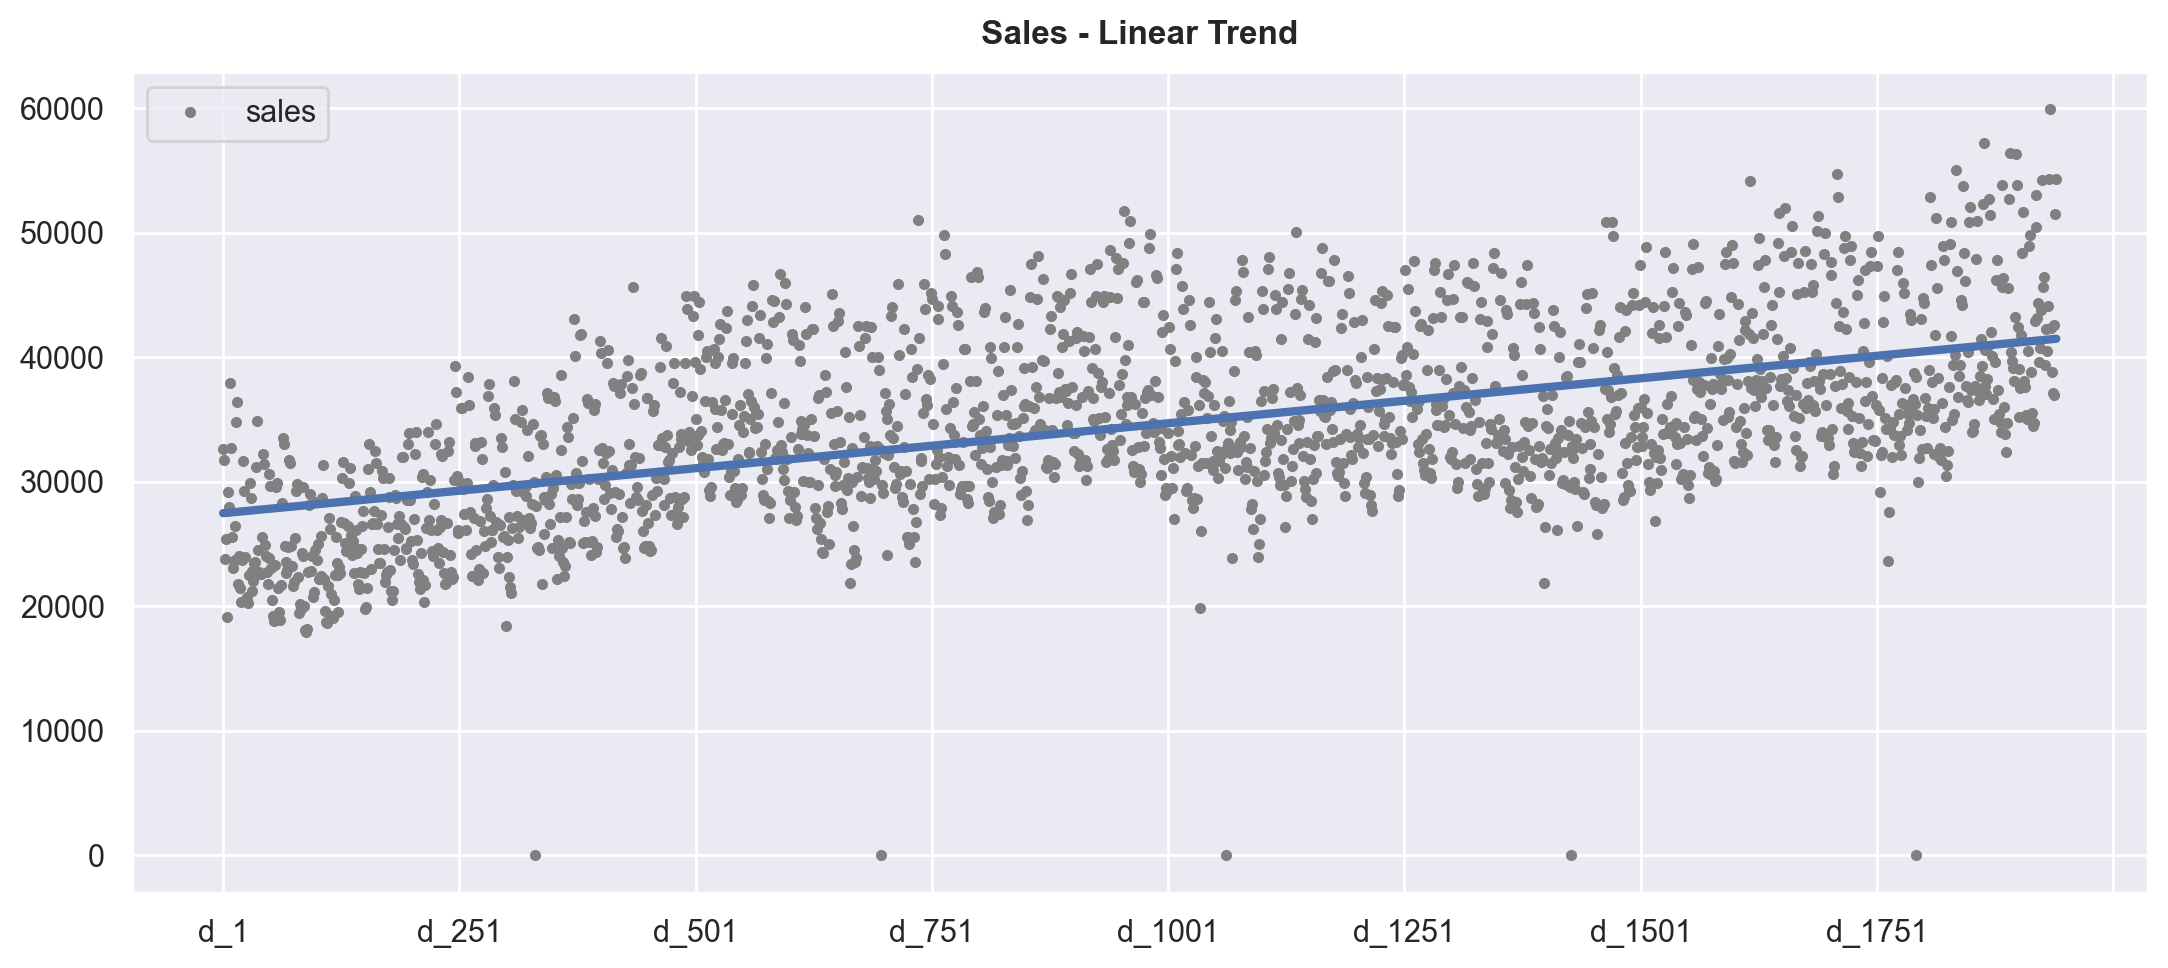

In [344]:
ax = all_sales.plot(style=".", color="0.5", title="Sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

### Seasonality

In [345]:
import numpy as np

def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
    features = {}
    for i in range(1, order + 1):
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)

In [346]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
# plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [347]:
all_sales = all_sales.reset_index().rename({'index':'d'},axis=1)

In [348]:
merged_all_sales = all_sales.merge(calendar, how='left', on='d')[['date', 'sales']]
merged_all_sales

date  sales
0     2011-01-29  32631
1     2011-01-30  31749
2     2011-01-31  23783
3     2011-02-01  25412
4     2011-02-02  19146
...          ...    ...
1936  2016-05-18  37096
1937  2016-05-19  36963
1938  2016-05-20  42552
1939  2016-05-21  51518
1940  2016-05-22  54338

[1941 rows x 2 columns]

In [349]:
from datetime import datetime

#merged_all_sales['date'] = merged_all_sales['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
merged_all_sales['date'] = pd.to_datetime(merged_all_sales['date'])

<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

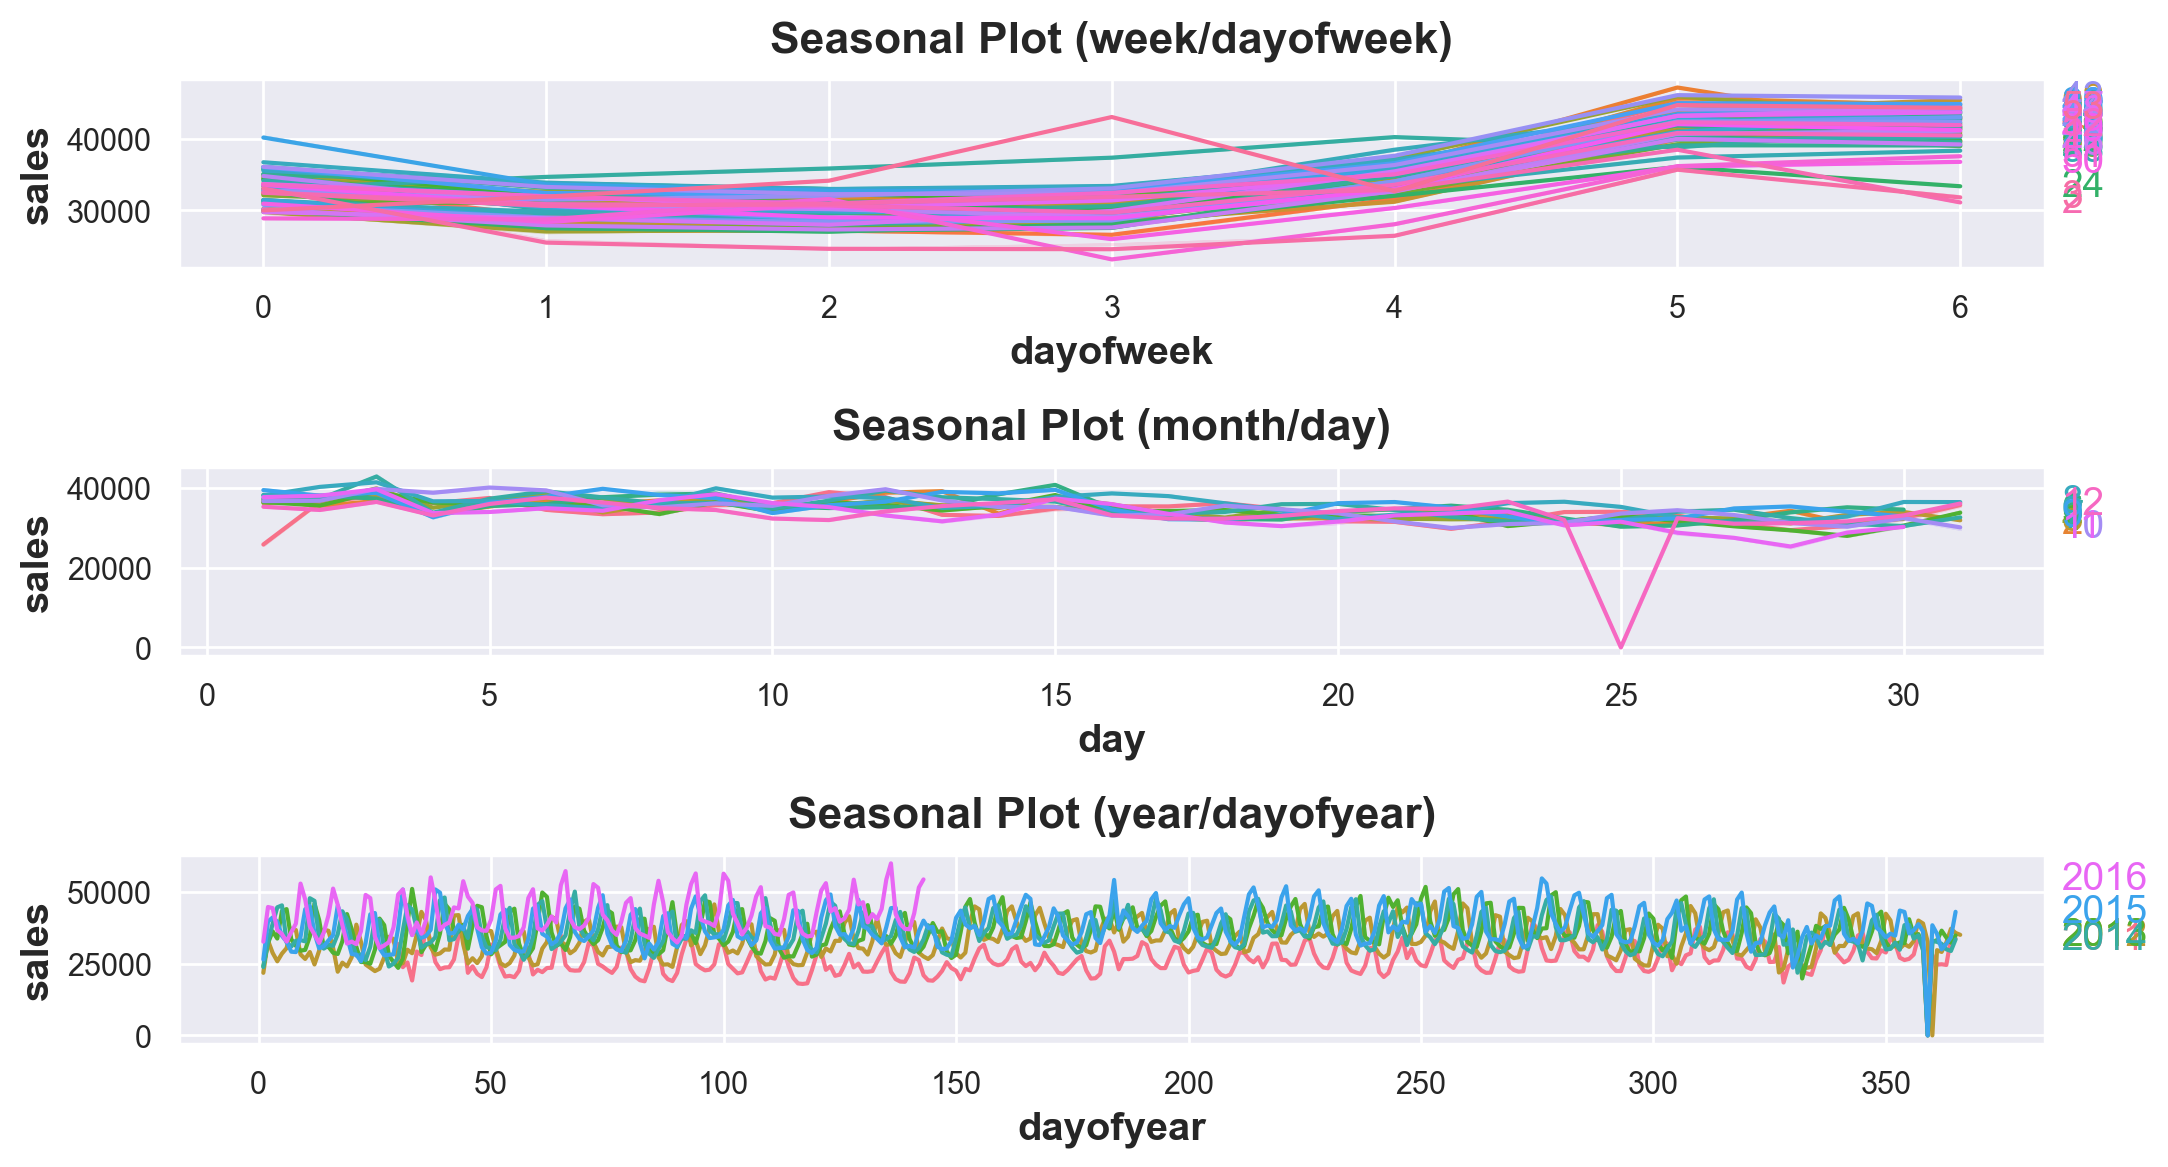

In [350]:
# days within a week
merged_all_sales["dayofweek"] = merged_all_sales.date.apply(lambda x: x.dayofweek)  # the x-axis (freq)
merged_all_sales["week"] = merged_all_sales.date.apply(lambda x: x.week)  # the seasonal period (period)

# days within a month
merged_all_sales["day"] = merged_all_sales.date.apply(lambda x: x.day)
merged_all_sales["month"] = merged_all_sales.date.apply(lambda x: x.month)

# days within a year
merged_all_sales["dayofyear"] = merged_all_sales.date.apply(lambda x: x.dayofyear)
merged_all_sales["year"] = merged_all_sales.date.apply(lambda x: x.year)

#merged_all_sales
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(11, 6))
seasonal_plot(merged_all_sales, y="sales", period="week", freq="dayofweek", ax=ax0)
seasonal_plot(merged_all_sales, y="sales", period="month", freq="day", ax=ax1)
seasonal_plot(merged_all_sales, y="sales", period="year", freq="dayofyear", ax=ax2)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

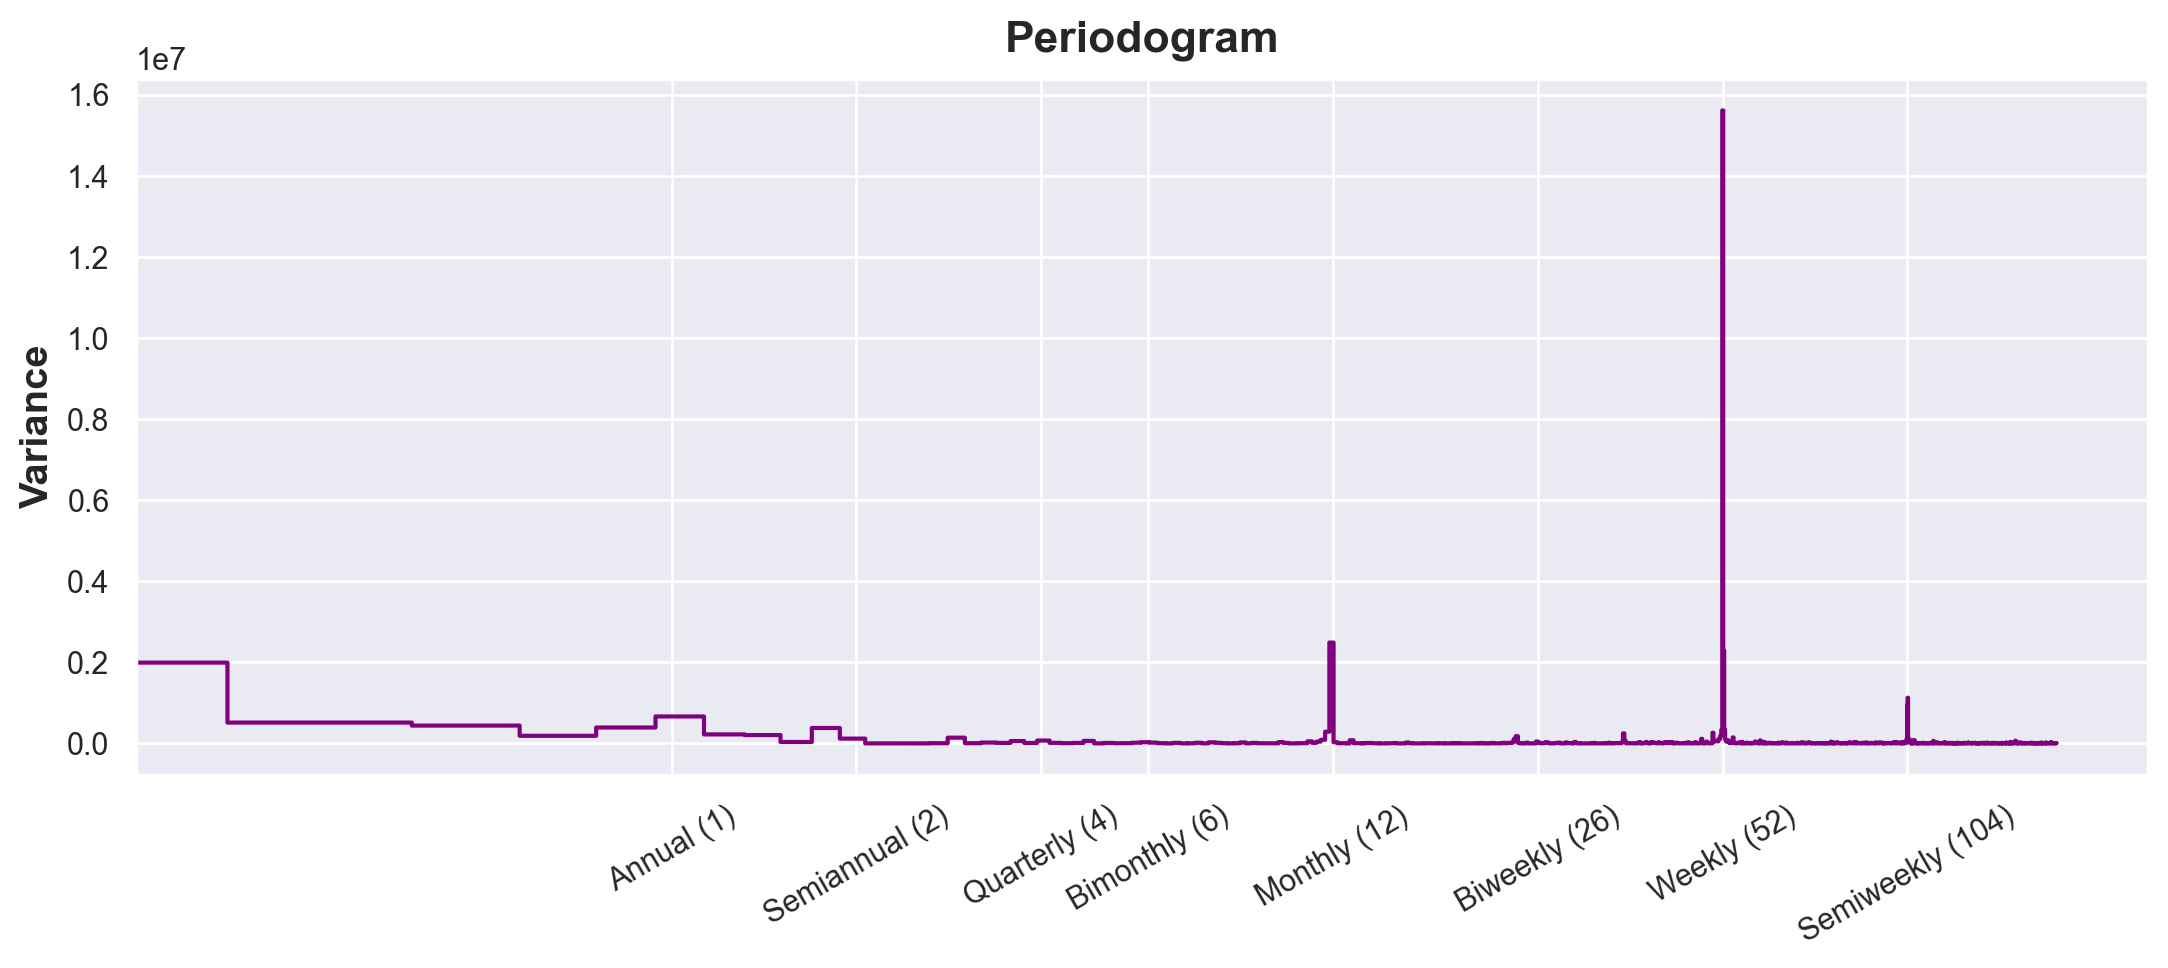

In [351]:
plot_periodogram(merged_all_sales.sales)

In [352]:
merged_all_sales.set_index('date', inplace=True)
merged_all_sales.index = merged_all_sales.index.to_period('D')

In [390]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="W", order=2)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=merged_all_sales.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

In [391]:
X

const   trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)
date                                                                     
2011-01-29    1.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0
2011-01-30    1.0     2.0     1.0     0.0     0.0     0.0     0.0     0.0
2011-01-31    1.0     3.0     0.0     1.0     0.0     0.0     0.0     0.0
2011-02-01    1.0     4.0     0.0     0.0     1.0     0.0     0.0     0.0
2011-02-02    1.0     5.0     0.0     0.0     0.0     1.0     0.0     0.0
...           ...     ...     ...     ...     ...     ...     ...     ...
2016-05-18    1.0  1937.0     0.0     0.0     0.0     1.0     0.0     0.0
2016-05-19    1.0  1938.0     0.0     0.0     0.0     0.0     1.0     0.0
2016-05-20    1.0  1939.0     0.0     0.0     0.0     0.0     0.0     1.0
2016-05-21    1.0  1940.0     0.0     0.0     0.0     0.0     0.0     0.0
2016-05-22    1.0  1941.0     1.0     0.0     0.0     0.0     0.0     0.0

[1941 rows x 8 columns]

In [389]:
dp.out_of_sample(90)

const   trend  sin(1,freq=W-SUN)  cos(1,freq=W-SUN)  \
2016-05-23    1.0  1942.0           0.000000           1.000000   
2016-05-24    1.0  1943.0           0.781831           0.623490   
2016-05-25    1.0  1944.0           0.974928          -0.222521   
2016-05-26    1.0  1945.0           0.433884          -0.900969   
2016-05-27    1.0  1946.0          -0.433884          -0.900969   
...           ...     ...                ...                ...   
2016-08-16    1.0  2027.0           0.781831           0.623490   
2016-08-17    1.0  2028.0           0.974928          -0.222521   
2016-08-18    1.0  2029.0           0.433884          -0.900969   
2016-08-19    1.0  2030.0          -0.433884          -0.900969   
2016-08-20    1.0  2031.0          -0.974928          -0.222521   

            sin(2,freq=W-SUN)  cos(2,freq=W-SUN)  
2016-05-23           0.000000           1.000000  
2016-05-24           0.974928          -0.222521  
2016-05-25          -0.433884          -0.900969  
2016-05-26          -0.781831           0.623490  
2016-05-27           0.781831           0.623490  
...                       ...                ...  
2016-08-16           0.974928          -0.222521  
2016-08-17          -0.433884          -0.900969  
2016-08-18          -0.781831           0.623490  
2016-08-19           0.781831           0.623490  
2016-08-20           0.433884          -0.900969  

[90 rows x 6 columns]

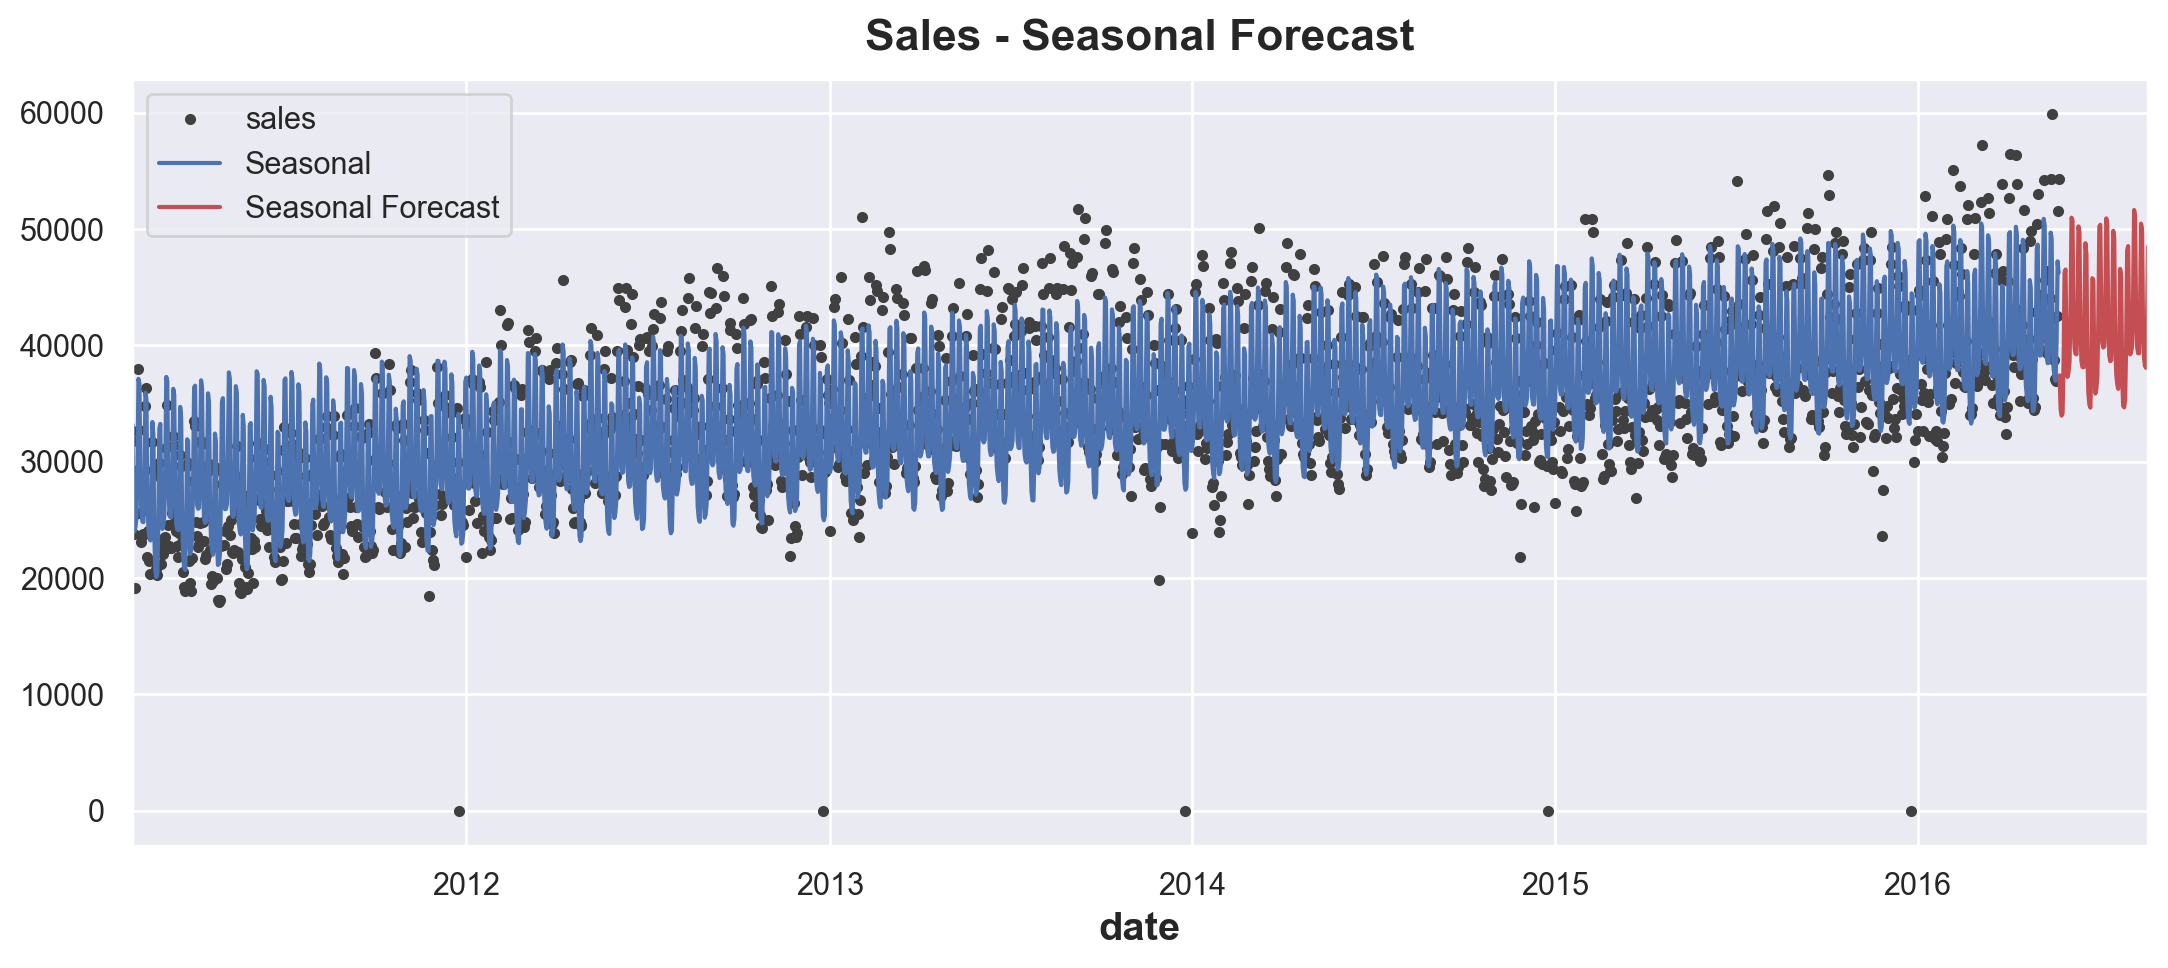

In [355]:
y = merged_all_sales["sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

### Cycle

In [356]:
df = pd.DataFrame({'sales': y,
     'sales_lag1': y.shift(1),
     'sales_lag2': y.shift(2)})
df

sales  sales_lag1  sales_lag2
date                                     
2011-01-29  32631         NaN         NaN
2011-01-30  31749     32631.0         NaN
2011-01-31  23783     31749.0     32631.0
2011-02-01  25412     23783.0     31749.0
2011-02-02  19146     25412.0     23783.0
...           ...         ...         ...
2016-05-18  37096     38777.0     42362.0
2016-05-19  36963     37096.0     38777.0
2016-05-20  42552     36963.0     37096.0
2016-05-21  51518     42552.0     36963.0
2016-05-22  54338     51518.0     42552.0

[1941 rows x 3 columns]

In [357]:
from statsmodels.graphics.tsaplots import plot_pacf


# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     #lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

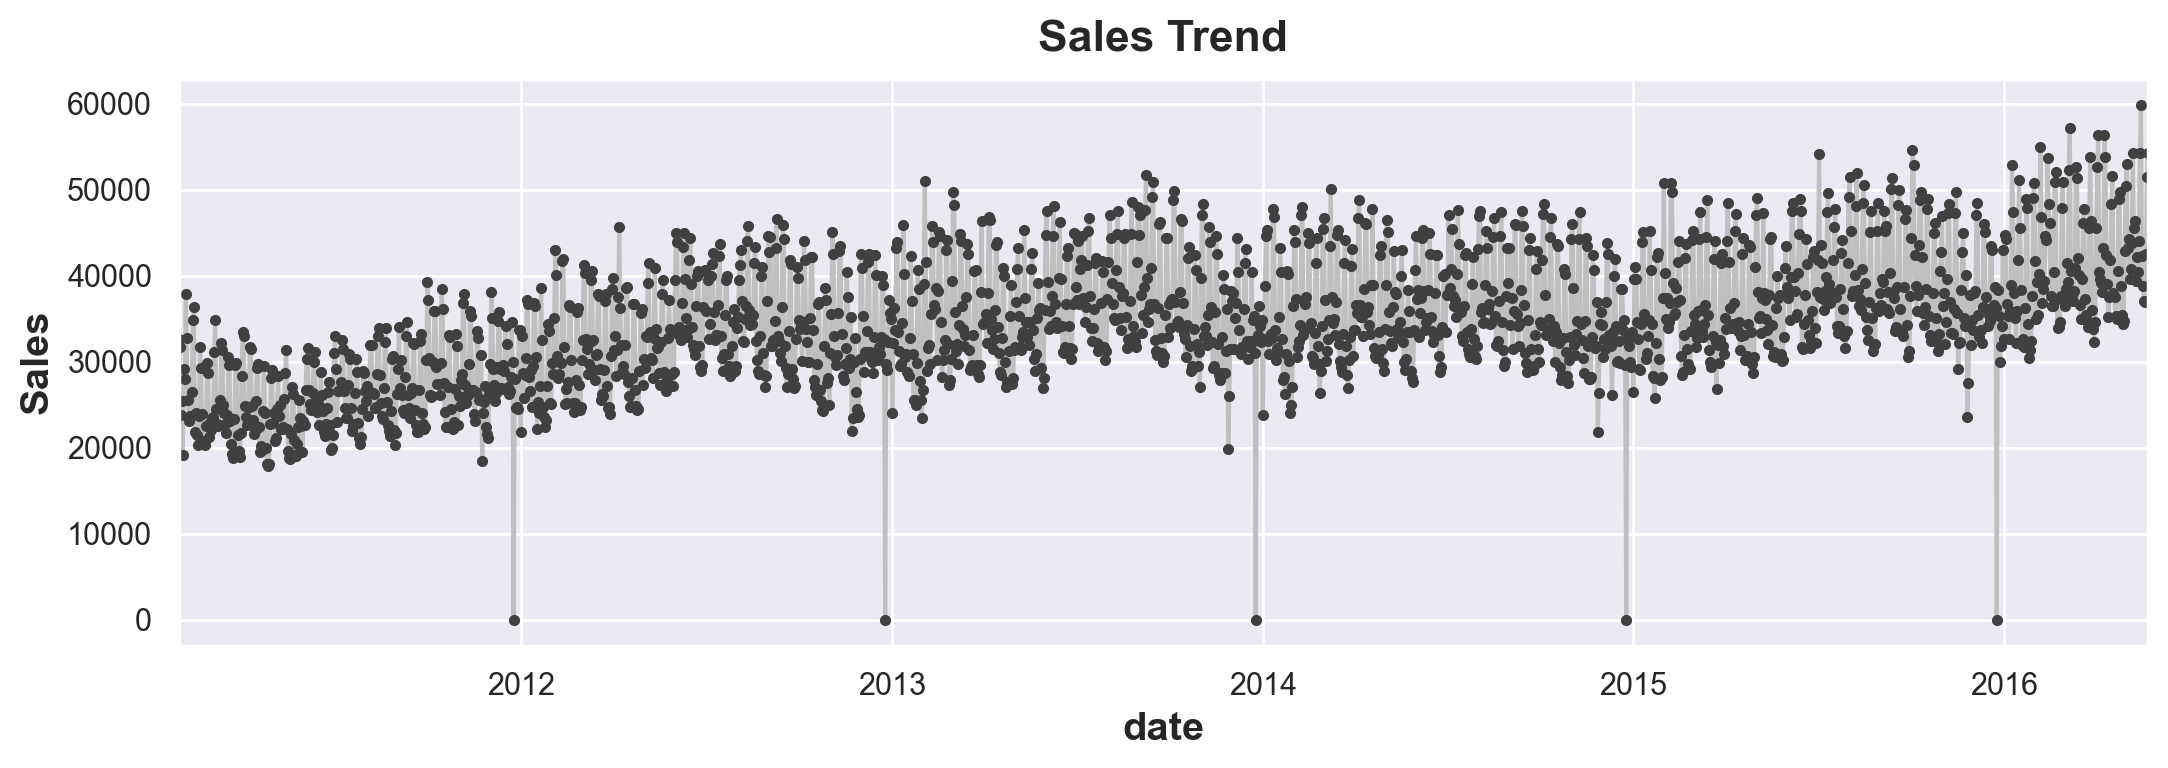

In [358]:
ax = merged_all_sales.sales.plot(title='Sales Trend', **plot_params)
_ = ax.set(ylabel="Sales")

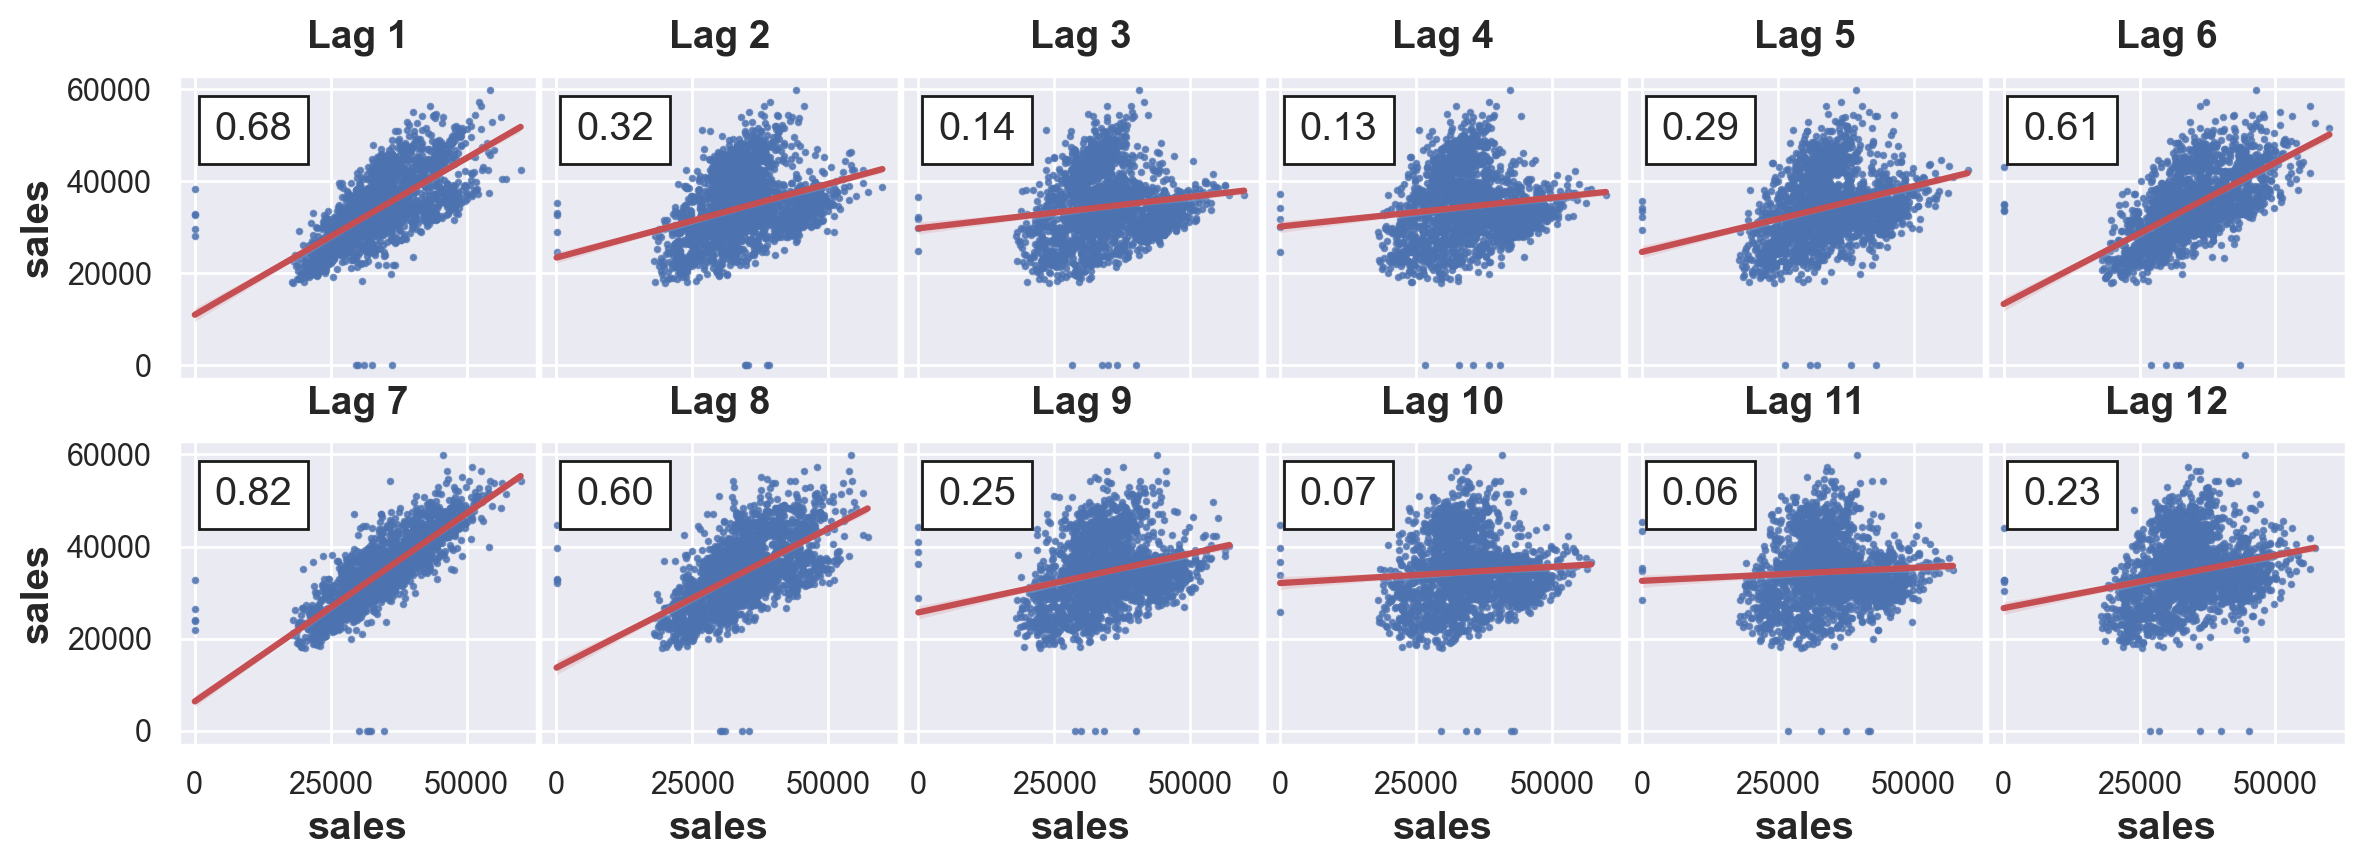

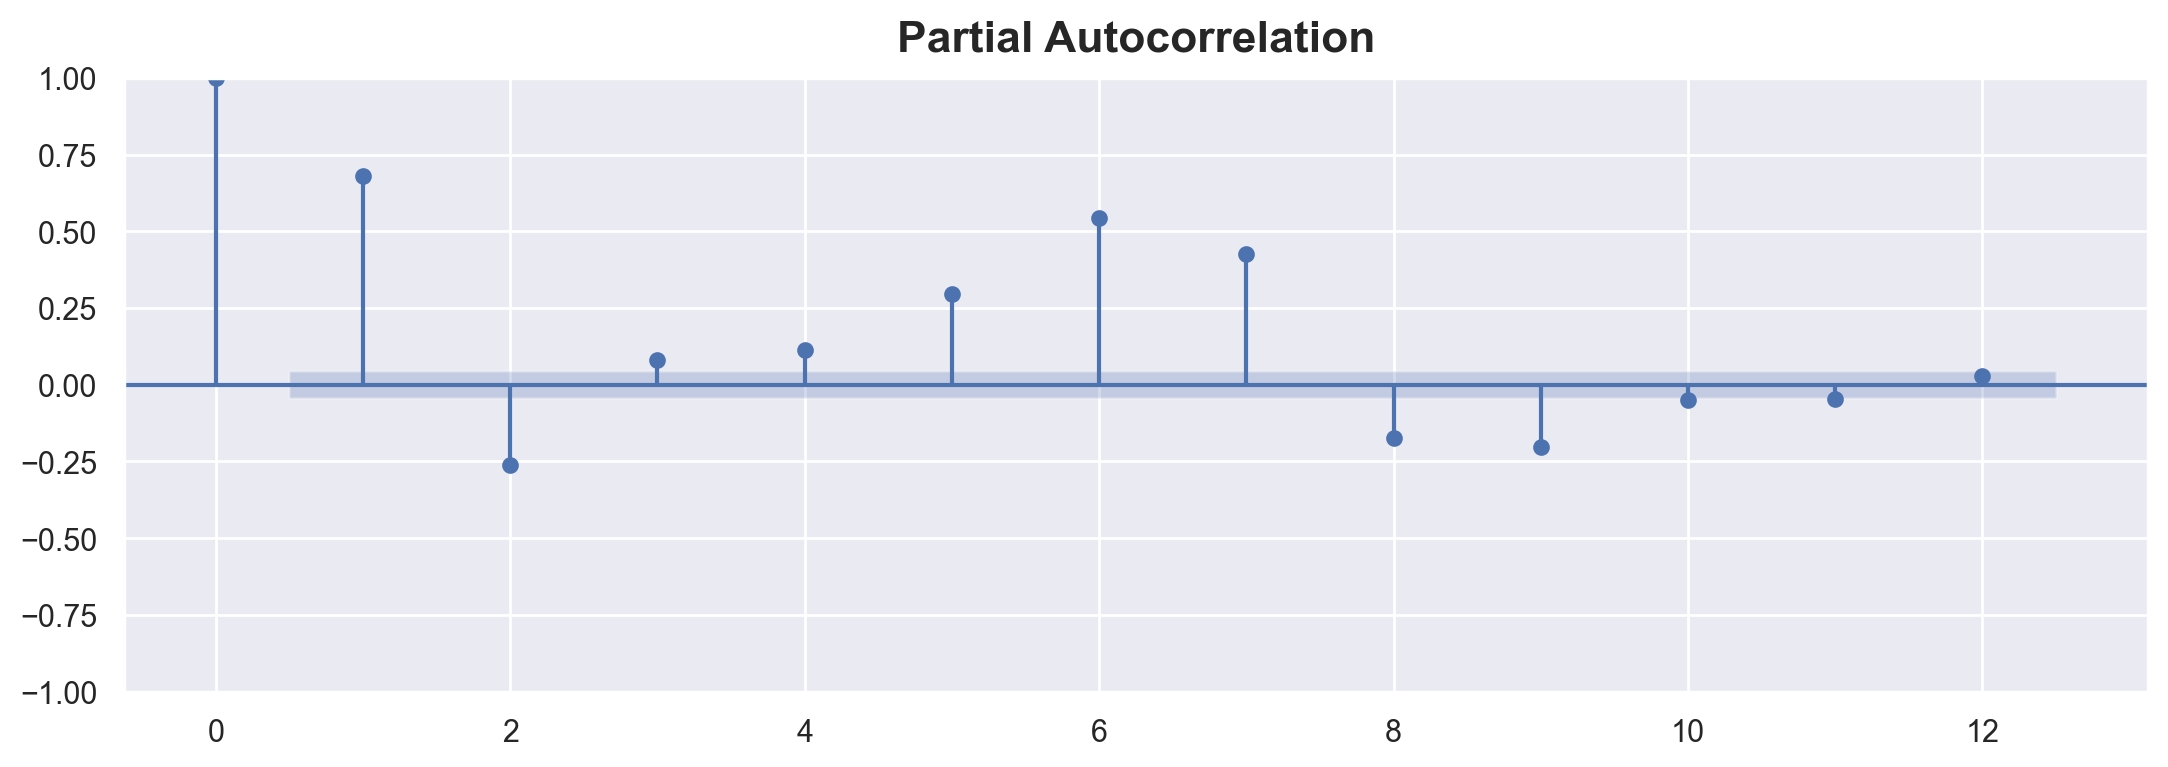

In [359]:
_ = plot_lags(merged_all_sales.sales, lags=12, nrows=2)
_ = plot_pacf(merged_all_sales.sales, lags=12)

In [360]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(merged_all_sales.sales, lags=8)
X = X.fillna(0.0)

In [361]:
from sklearn.model_selection import train_test_split
# Create target series and data splits
y = merged_all_sales.sales.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

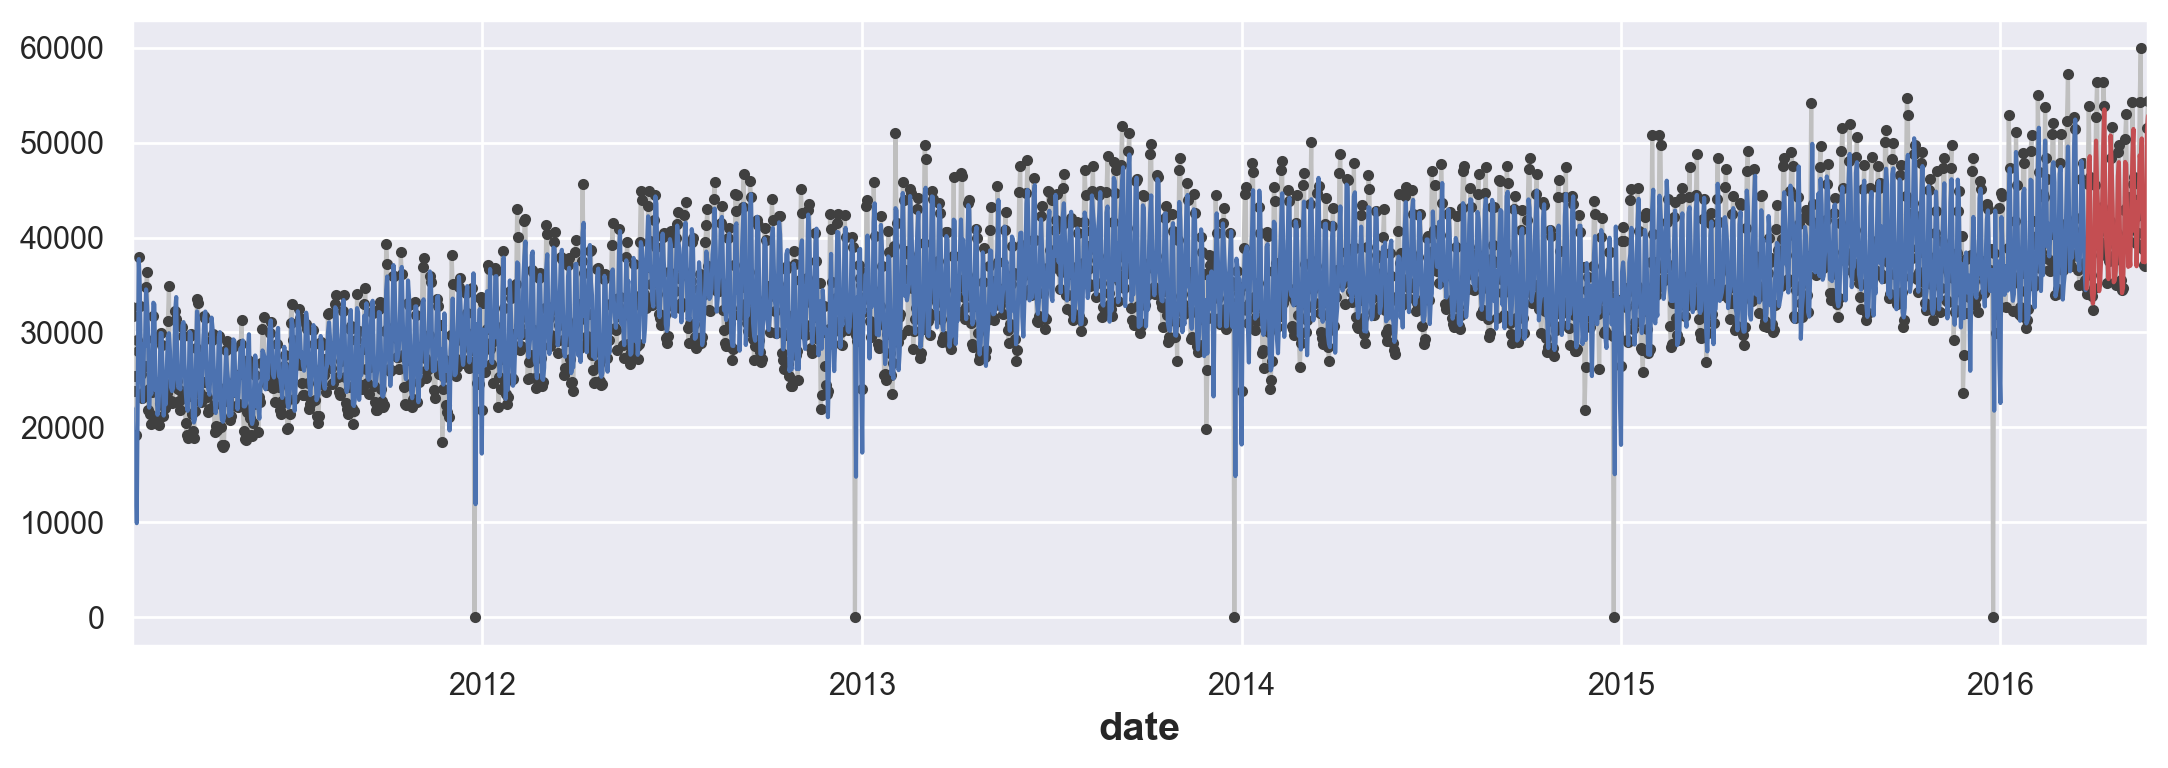

In [362]:
#ax = y_train[-100:].plot(**plot_params)
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
#ax = y_pred[-100:].plot(ax=ax)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

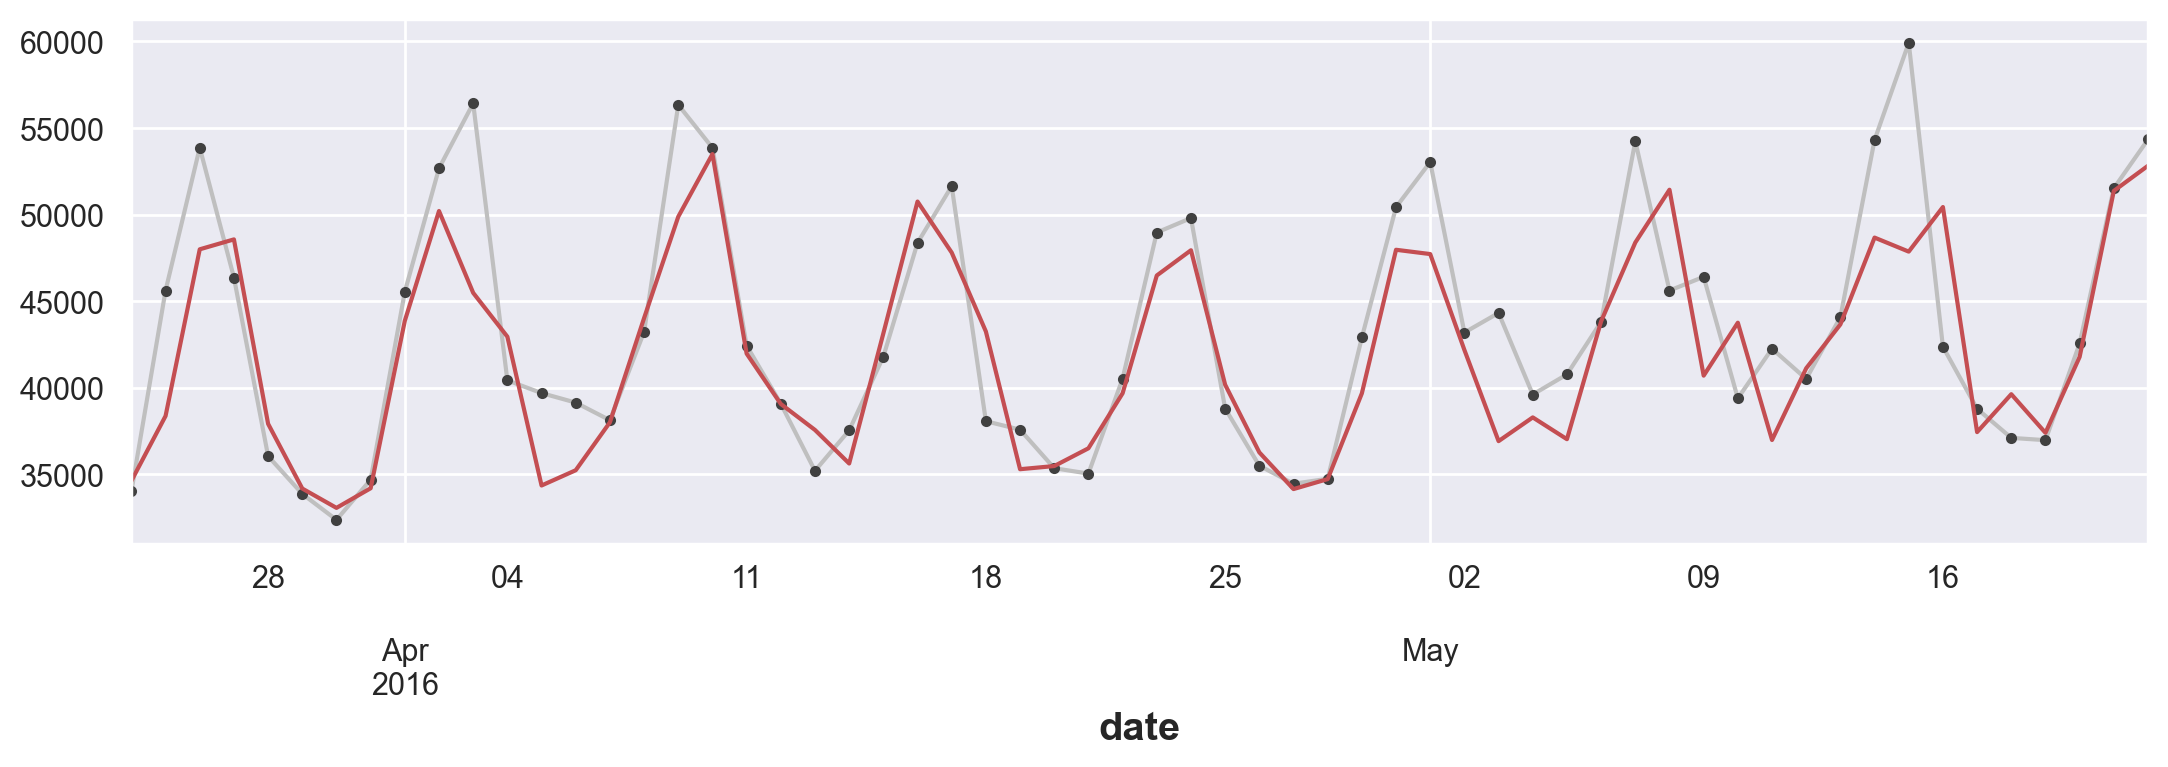

In [363]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

## Single Item Analysis

In [364]:
item_id = 'HOBBIES_1_002'
selected_item = train_data[train_data['item_id']==item_id]
selected_item

id        item_id    dept_id   cat_id  \
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
3050   HOBBIES_1_002_CA_2_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
6099   HOBBIES_1_002_CA_3_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
9148   HOBBIES_1_002_CA_4_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
12197  HOBBIES_1_002_TX_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
15246  HOBBIES_1_002_TX_2_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
18295  HOBBIES_1_002_TX_3_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
21344  HOBBIES_1_002_WI_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
24393  HOBBIES_1_002_WI_2_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
27442  HOBBIES_1_002_WI_3_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1932  d_1933  d_1934  \
1         CA_1       CA    0    0    0    0  ...       0       1       2   
3050      CA_2       CA    0    0    0    0  ...       0       0       0   
6099      CA_3       CA    0    0    0    0  ...       0       0       0   
9148      CA_4       CA    0    0    0    0  ...       0       1       0   
12197     TX_1       TX    0    0    0    0  ...       0       0       0   
15246     TX_2       TX    0    0    0    0  ...       0       0       0   
18295     TX_3       TX    0    0    0    0  ...       0       0       0   
21344     WI_1       WI    0    0    0    0  ...       0       1       0   
24393     WI_2       WI    0    0    0    0  ...       0       1       0   
27442     WI_3       WI    0    0    0    0  ...       0       0       0   

       d_1935  d_1936  d_1937  d_1938  d_1939  d_1940  d_1941  
1           1       1       0       0       0       0       0  
3050        0       0       0       0       0       1       1  
6099        0       0       0       0       0       0       0  
9148        0       0       0       0       2       0       0  
12197       0       0       0       1       0       0       0  
15246       0       0       1       0       0       0       1  
18295       0       0       0       0       0       0       0  
21344       1       0       0       0       1       1       1  
24393       0       1       0       1       0       1       1  
27442       0       0       0       1       0       0       1  

[10 rows x 1947 columns]

In [365]:
selected_item = selected_item.groupby('item_id').sum()[day_columns].T

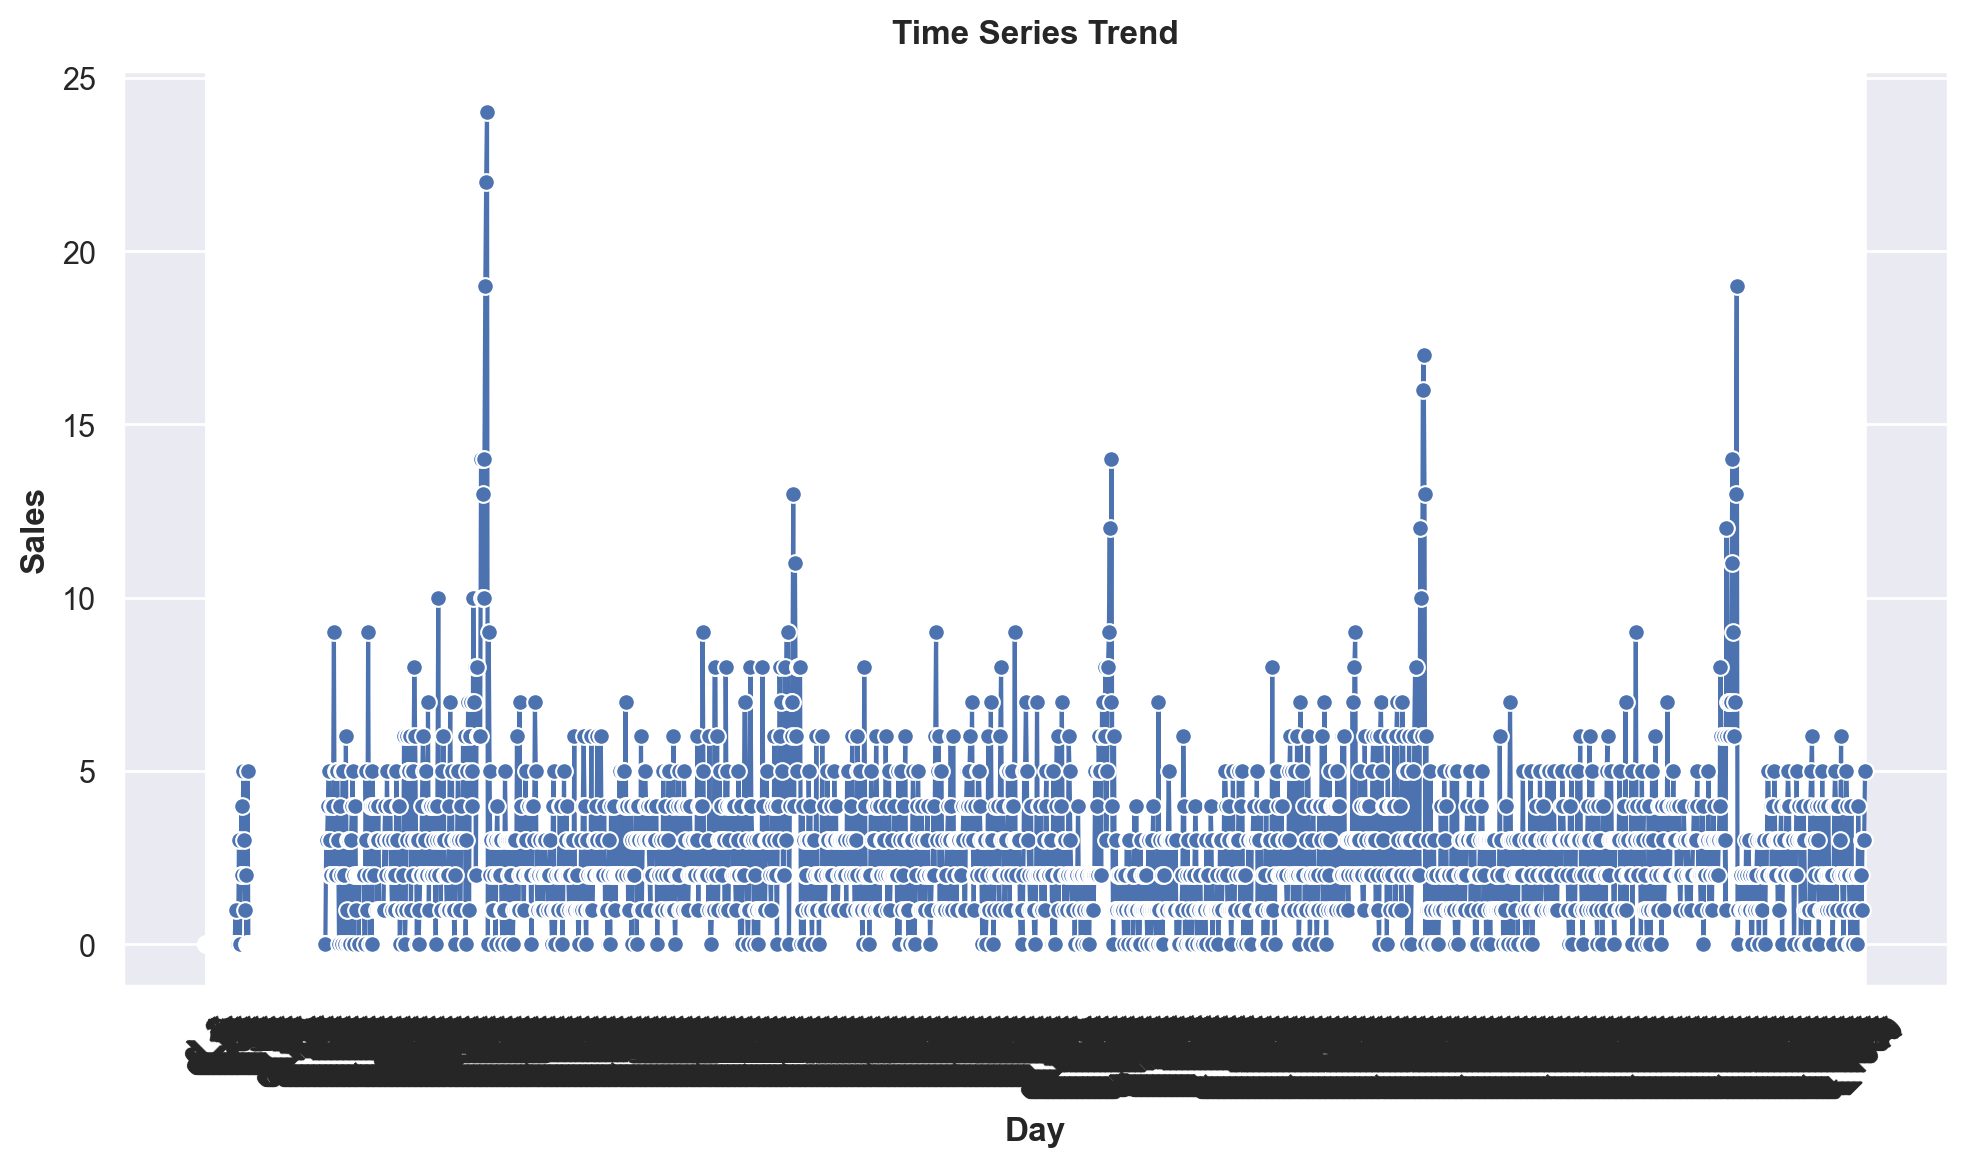

In [366]:
# 设置风格
sns.set(style="darkgrid")

# 绘制趋势图
plt.figure(figsize=(10, 6))
sns.lineplot(x=selected_item.index, y=item_id, data=selected_item, marker='o')
plt.title('Time Series Trend')
plt.xlabel('Day')
plt.ylabel('Sales')
plt.xticks(rotation=45)  # 旋转x轴标签
plt.show()

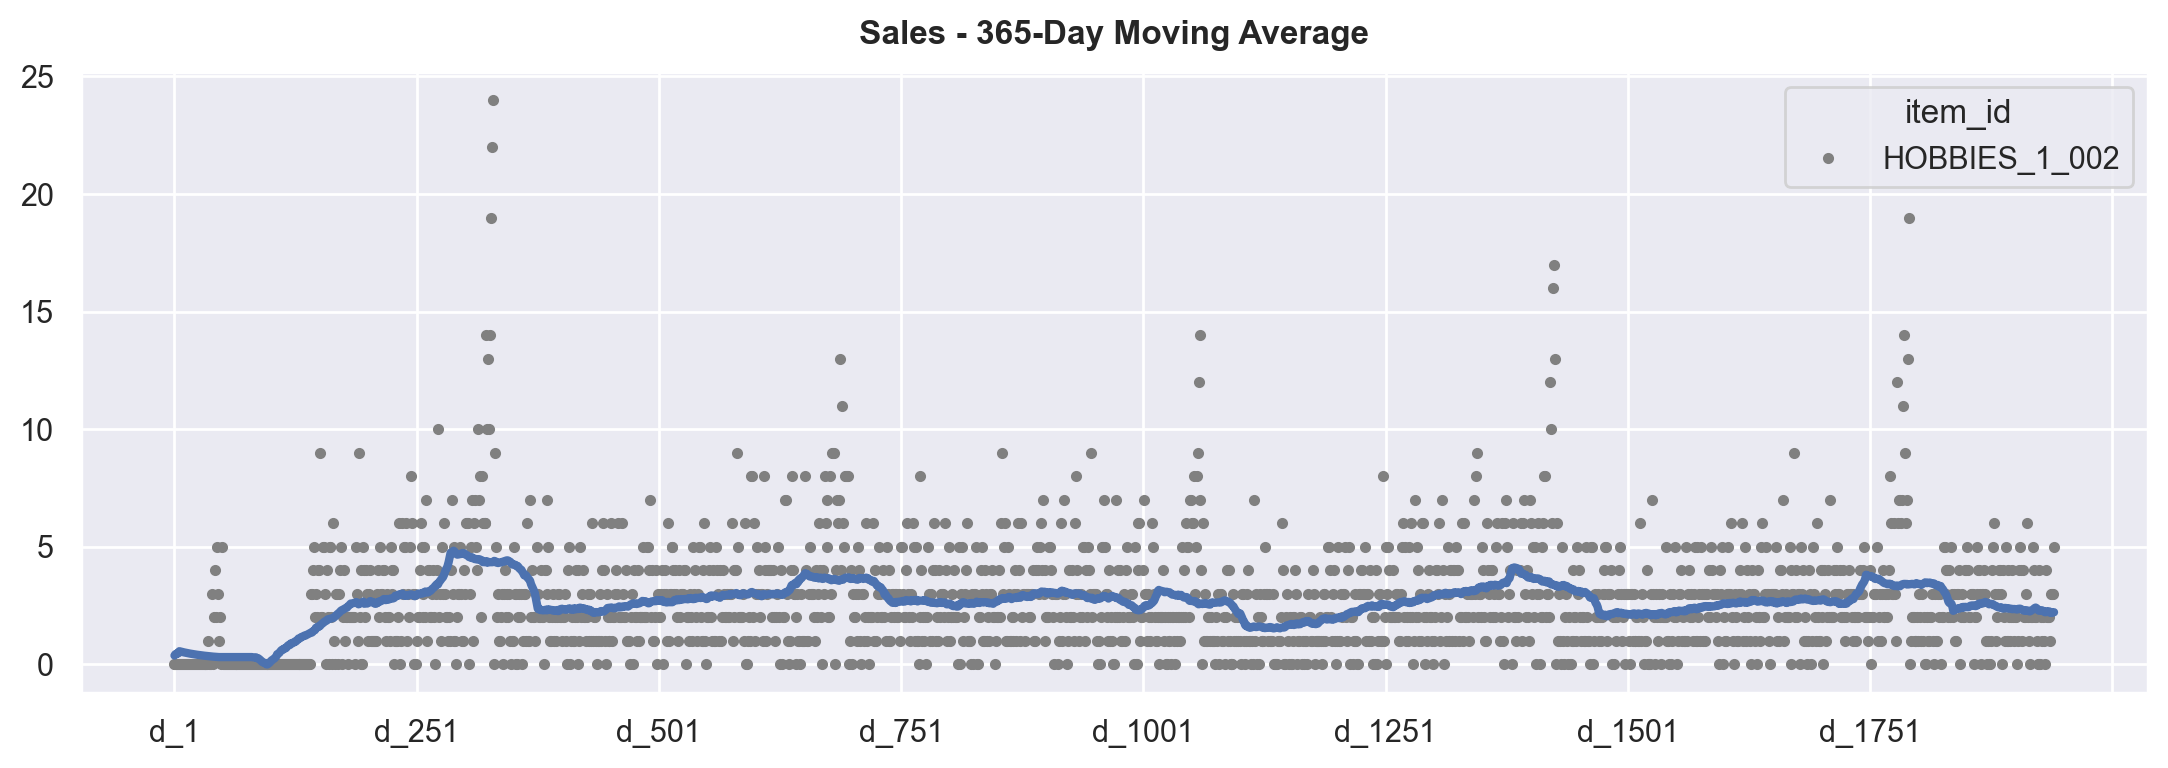

In [367]:
moving_average = selected_item.rolling(
    window=90,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=45,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = selected_item.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Sales - 365-Day Moving Average", legend=False,
);

In [368]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=selected_item.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

const  trend
d_1    1.0    1.0
d_2    1.0    2.0
d_3    1.0    3.0
d_4    1.0    4.0
d_5    1.0    5.0

In [369]:
from sklearn.linear_model import LinearRegression

y = selected_item[item_id]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

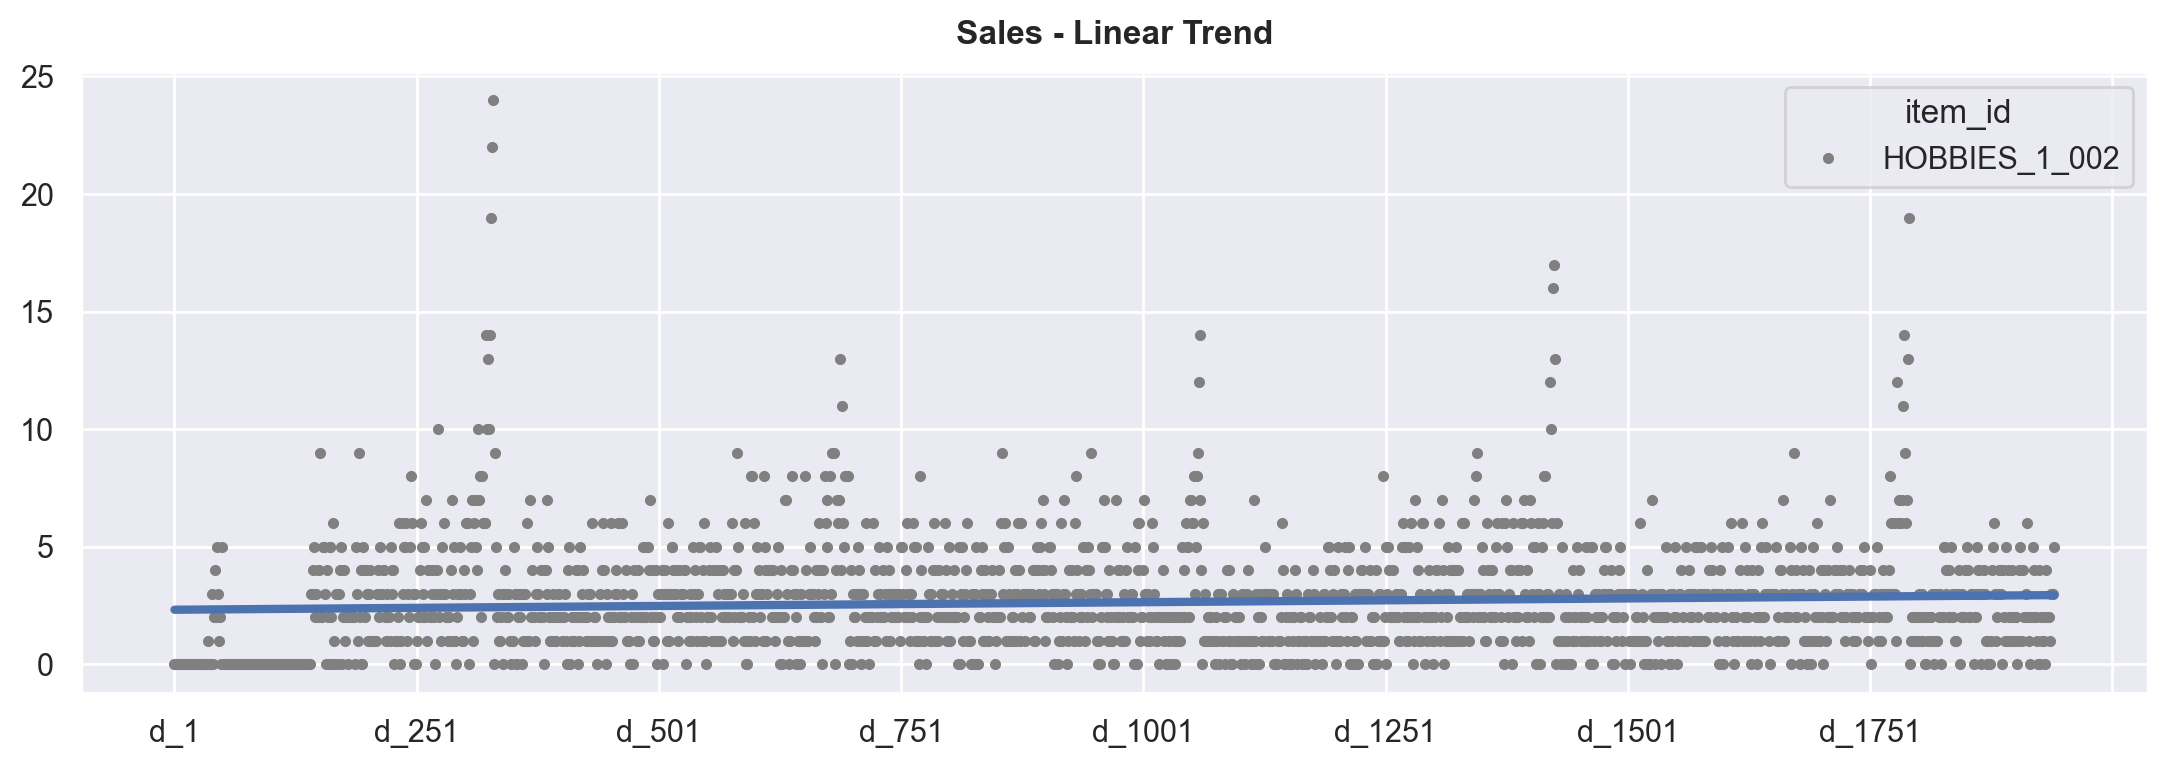

In [370]:
ax = selected_item.plot(style=".", color="0.5", title="Sales - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [371]:
selected_item

item_id  HOBBIES_1_002
d_1                  0
d_2                  0
d_3                  0
d_4                  0
d_5                  0
...                ...
d_1937               1
d_1938               3
d_1939               3
d_1940               3
d_1941               5

[1941 rows x 1 columns]

In [372]:
selected_item.reset_index()['index']

0          d_1
1          d_2
2          d_3
3          d_4
4          d_5
         ...  
1936    d_1937
1937    d_1938
1938    d_1939
1939    d_1940
1940    d_1941
Name: index, Length: 1941, dtype: object

<Axes: title={'center': 'Seasonal Plot (year/dayofyear)'}, xlabel='dayofyear', ylabel='sales'>

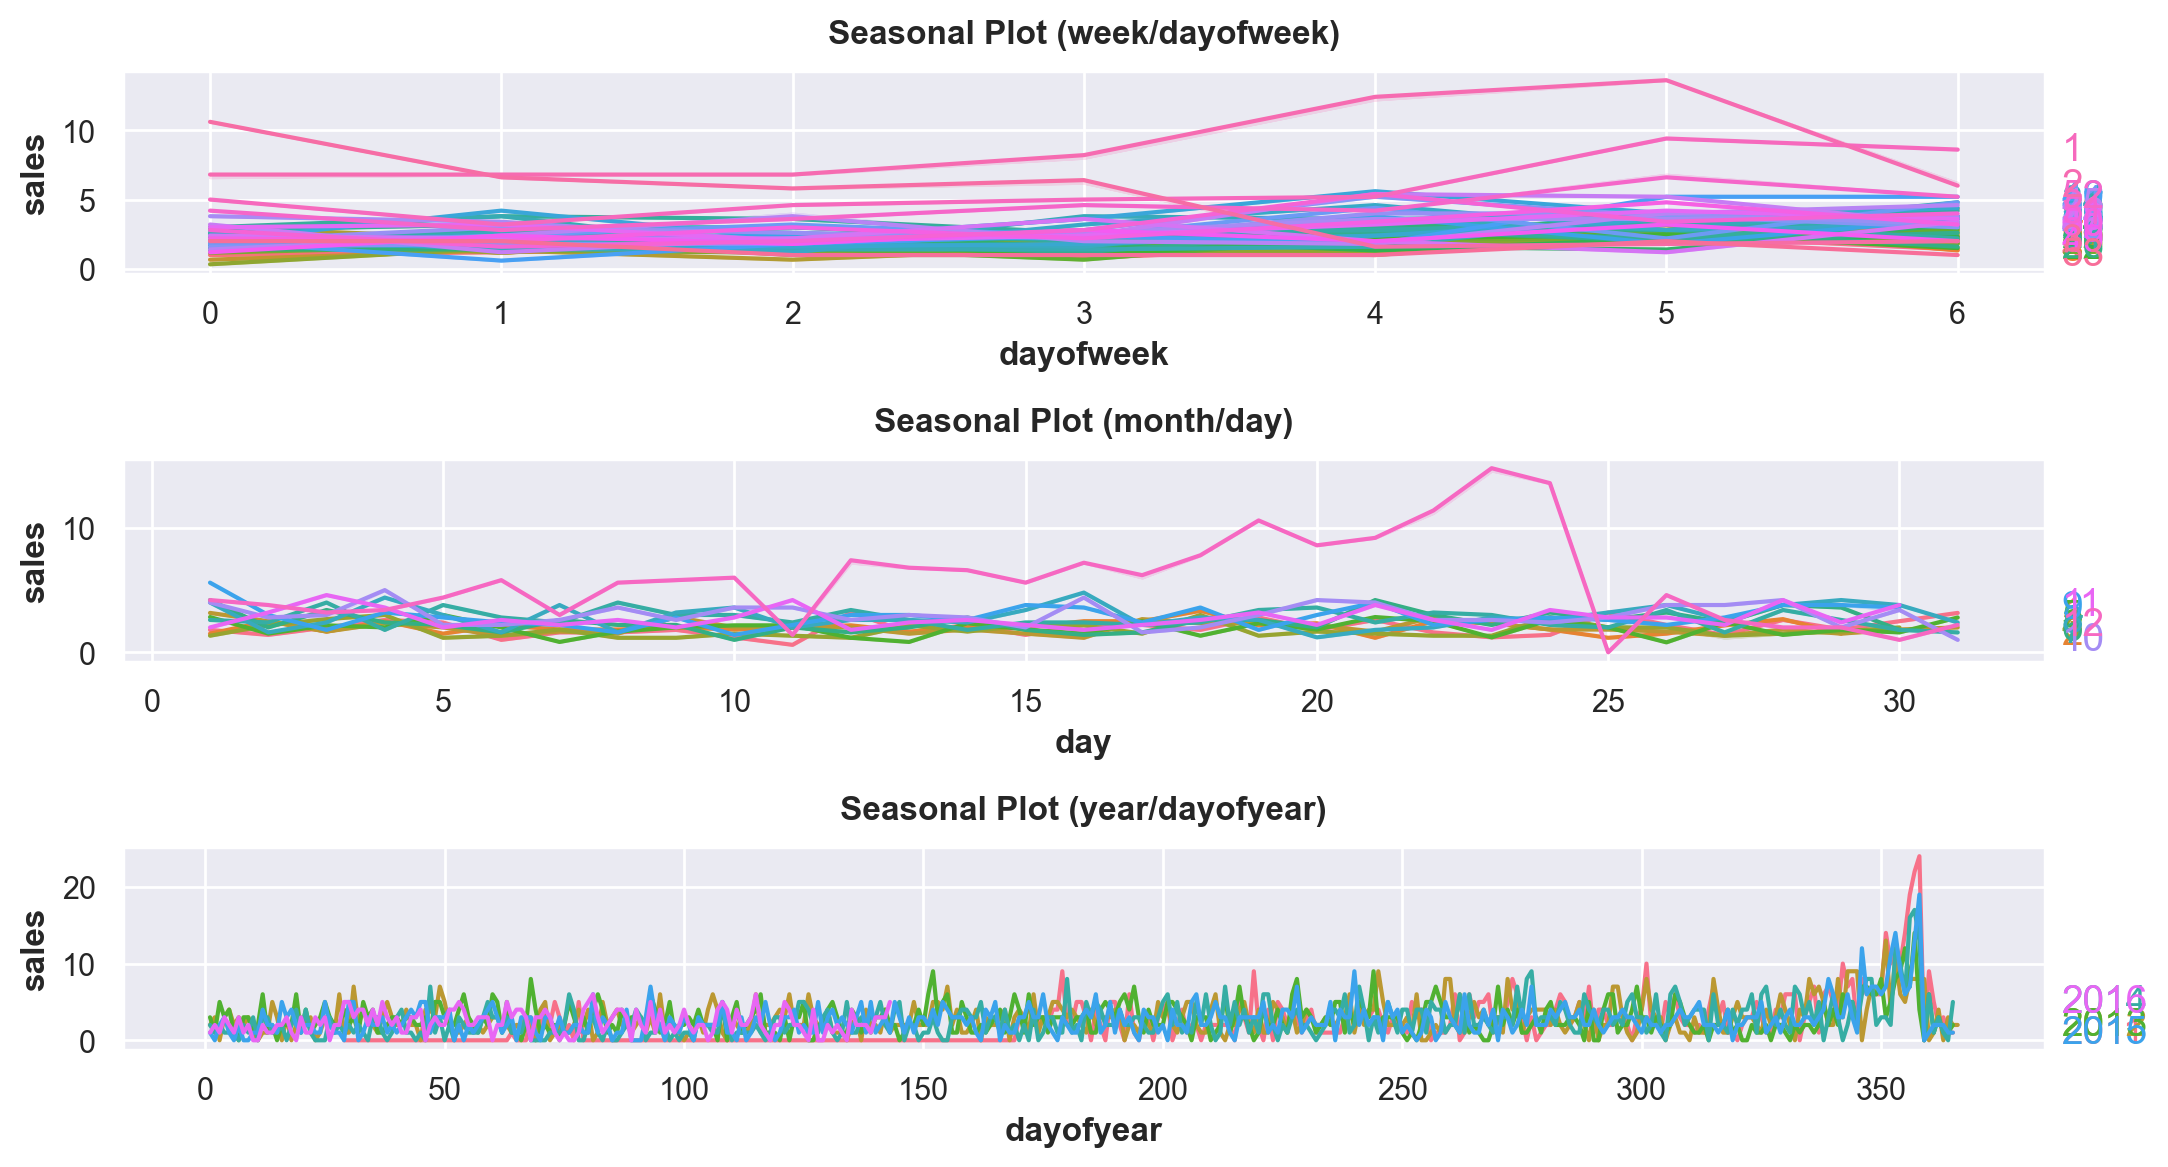

In [373]:
merged_all_sales = selected_item.reset_index().merge(calendar, how='left', left_on='index', right_on='d')\
    [['date', item_id]].rename({item_id: 'sales'}, axis=1)

from datetime import datetime

#merged_all_sales['date'] = merged_all_sales['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
merged_all_sales['date'] = pd.to_datetime(merged_all_sales['date'])

# days within a week
merged_all_sales["dayofweek"] = merged_all_sales.date.apply(lambda x: x.dayofweek)  # the x-axis (freq)
merged_all_sales["week"] = merged_all_sales.date.apply(lambda x: x.week)  # the seasonal period (period)

# days within a month
merged_all_sales["day"] = merged_all_sales.date.apply(lambda x: x.day)
merged_all_sales["month"] = merged_all_sales.date.apply(lambda x: x.month)

# days within a year
merged_all_sales["dayofyear"] = merged_all_sales.date.apply(lambda x: x.dayofyear)
merged_all_sales["year"] = merged_all_sales.date.apply(lambda x: x.year)

#merged_all_sales
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(11, 6))
seasonal_plot(merged_all_sales, y="sales", period="week", freq="dayofweek", ax=ax0)
seasonal_plot(merged_all_sales, y="sales", period="month", freq="day", ax=ax1)
seasonal_plot(merged_all_sales, y="sales", period="year", freq="dayofyear", ax=ax2)

<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

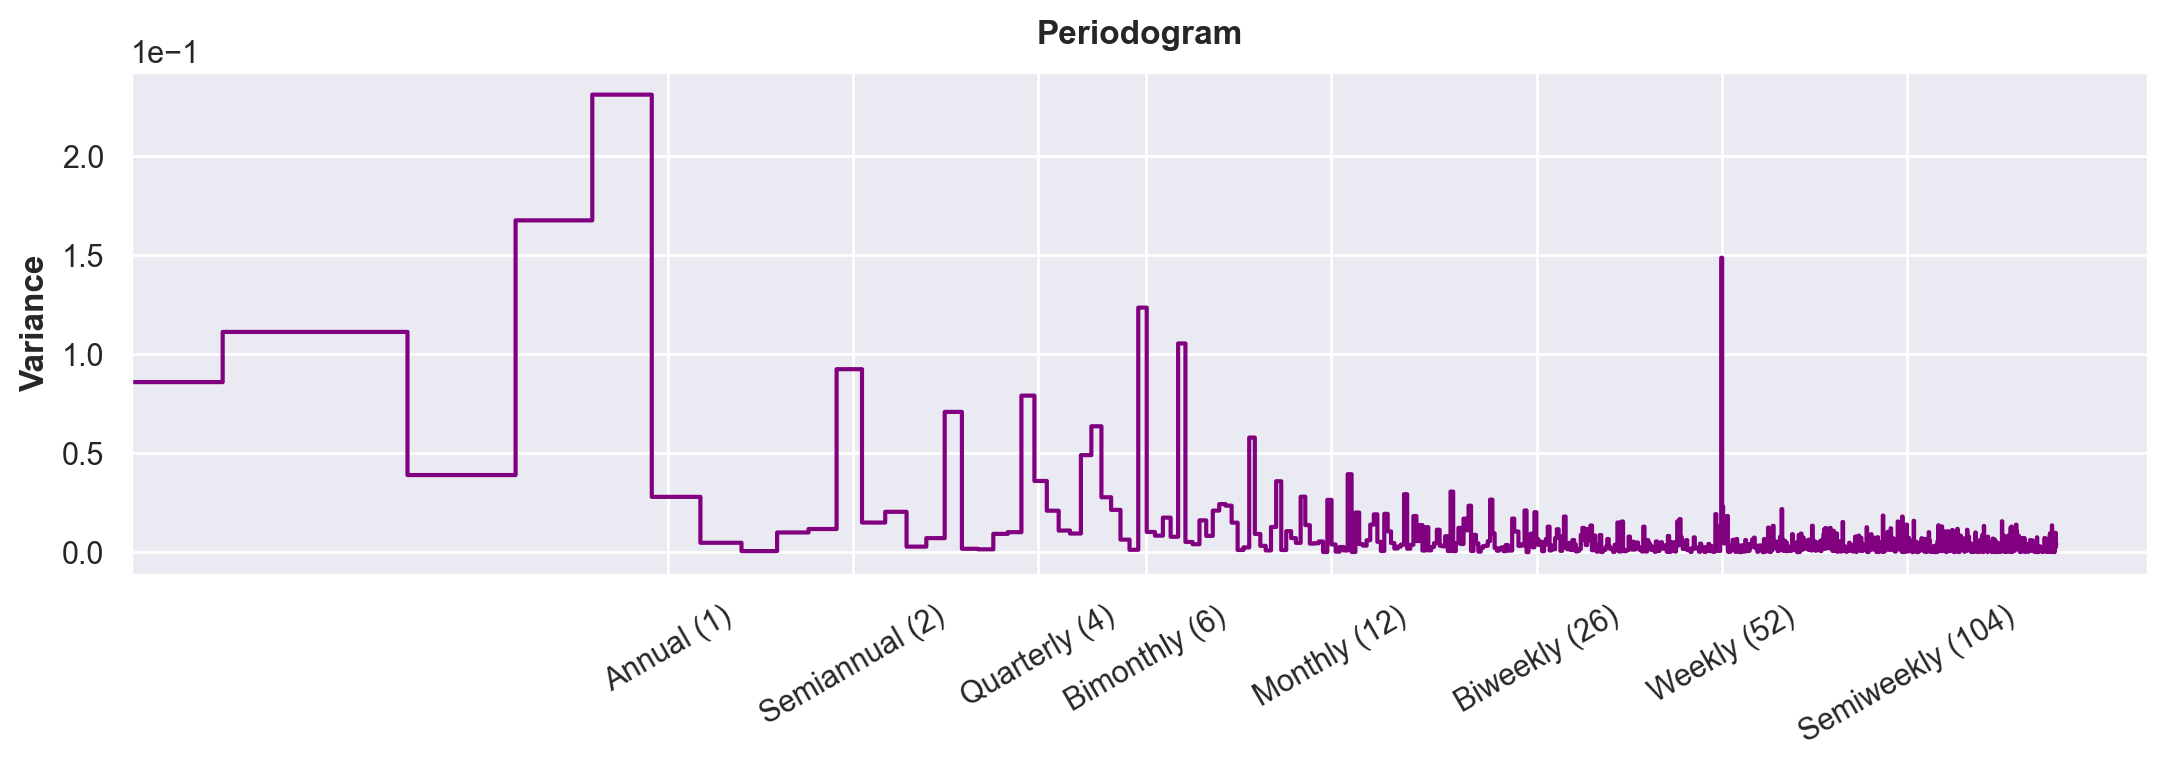

In [374]:
plot_periodogram(merged_all_sales.sales)

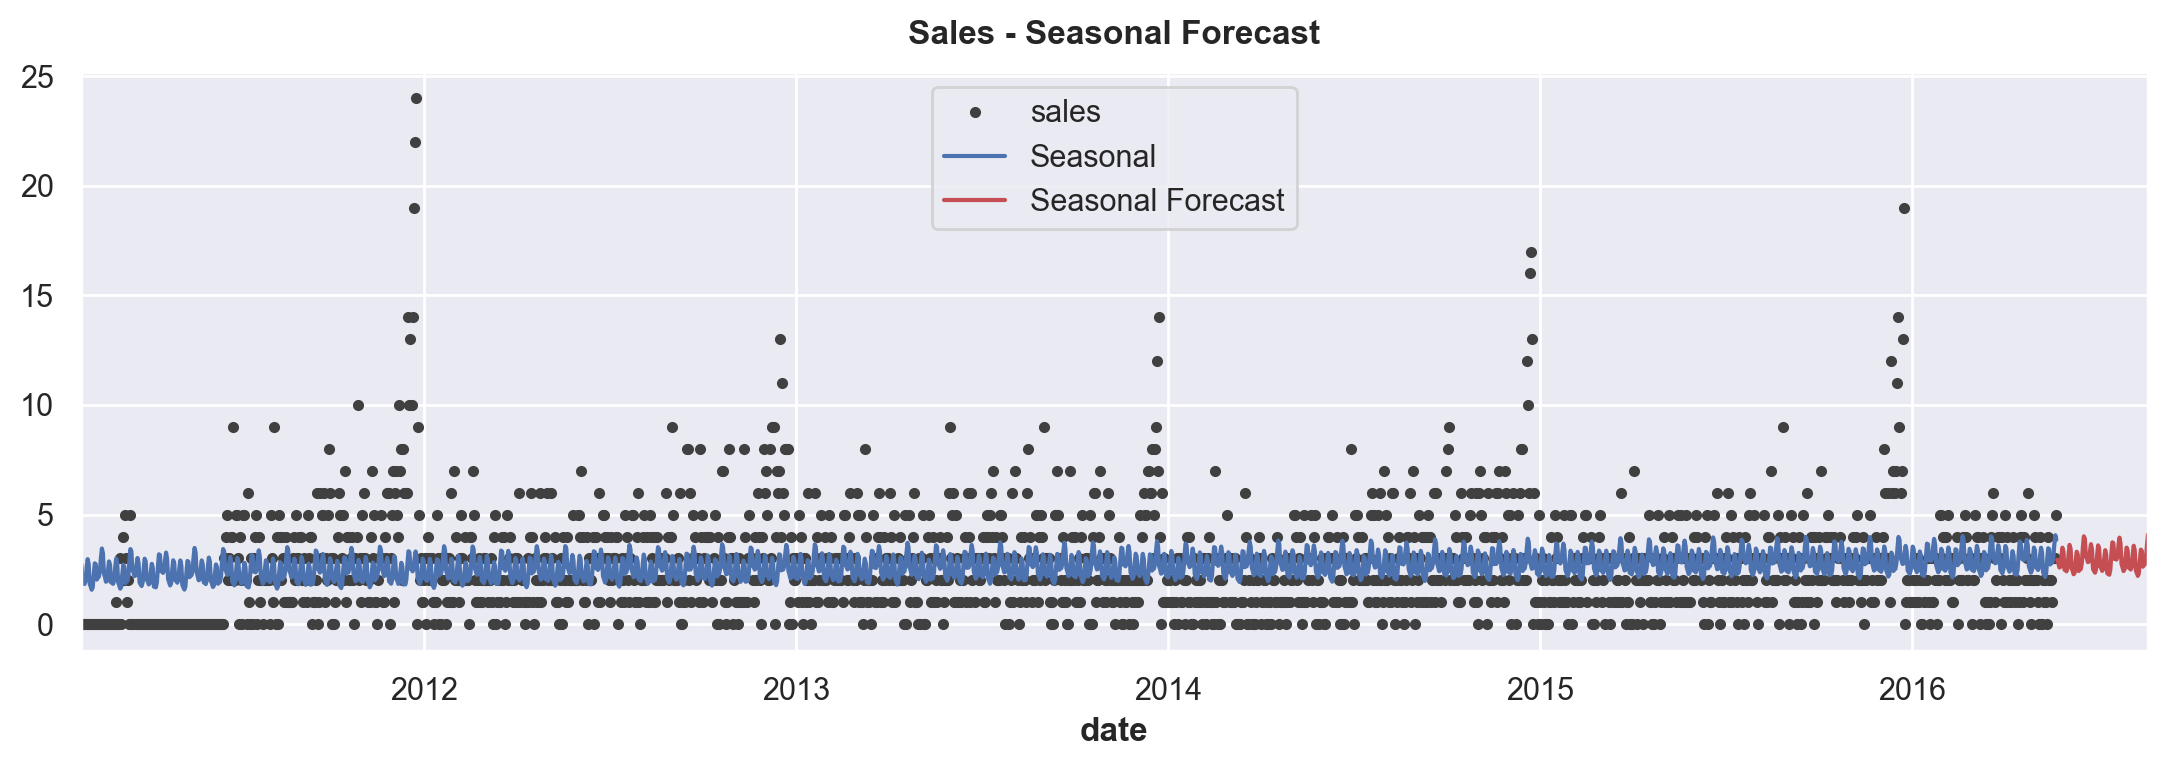

In [375]:
merged_all_sales.set_index('date', inplace=True)
merged_all_sales.index = merged_all_sales.index.to_period('D')

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="M", order=2)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=merged_all_sales.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

y = merged_all_sales["sales"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Sales - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

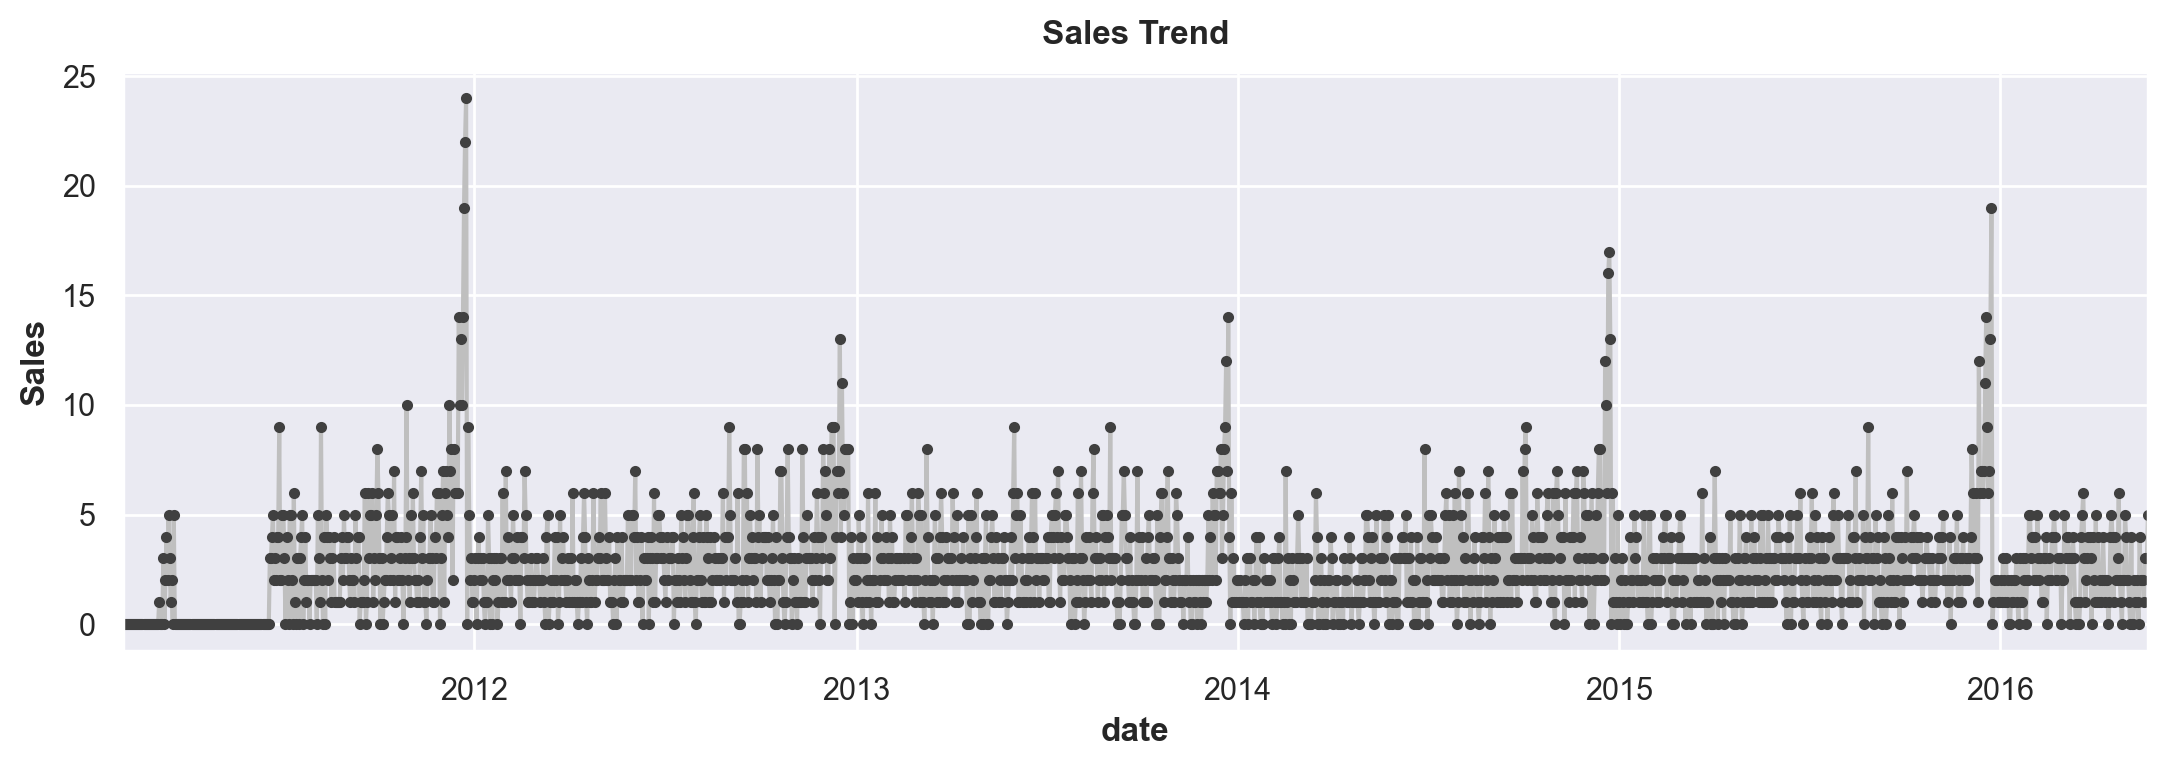

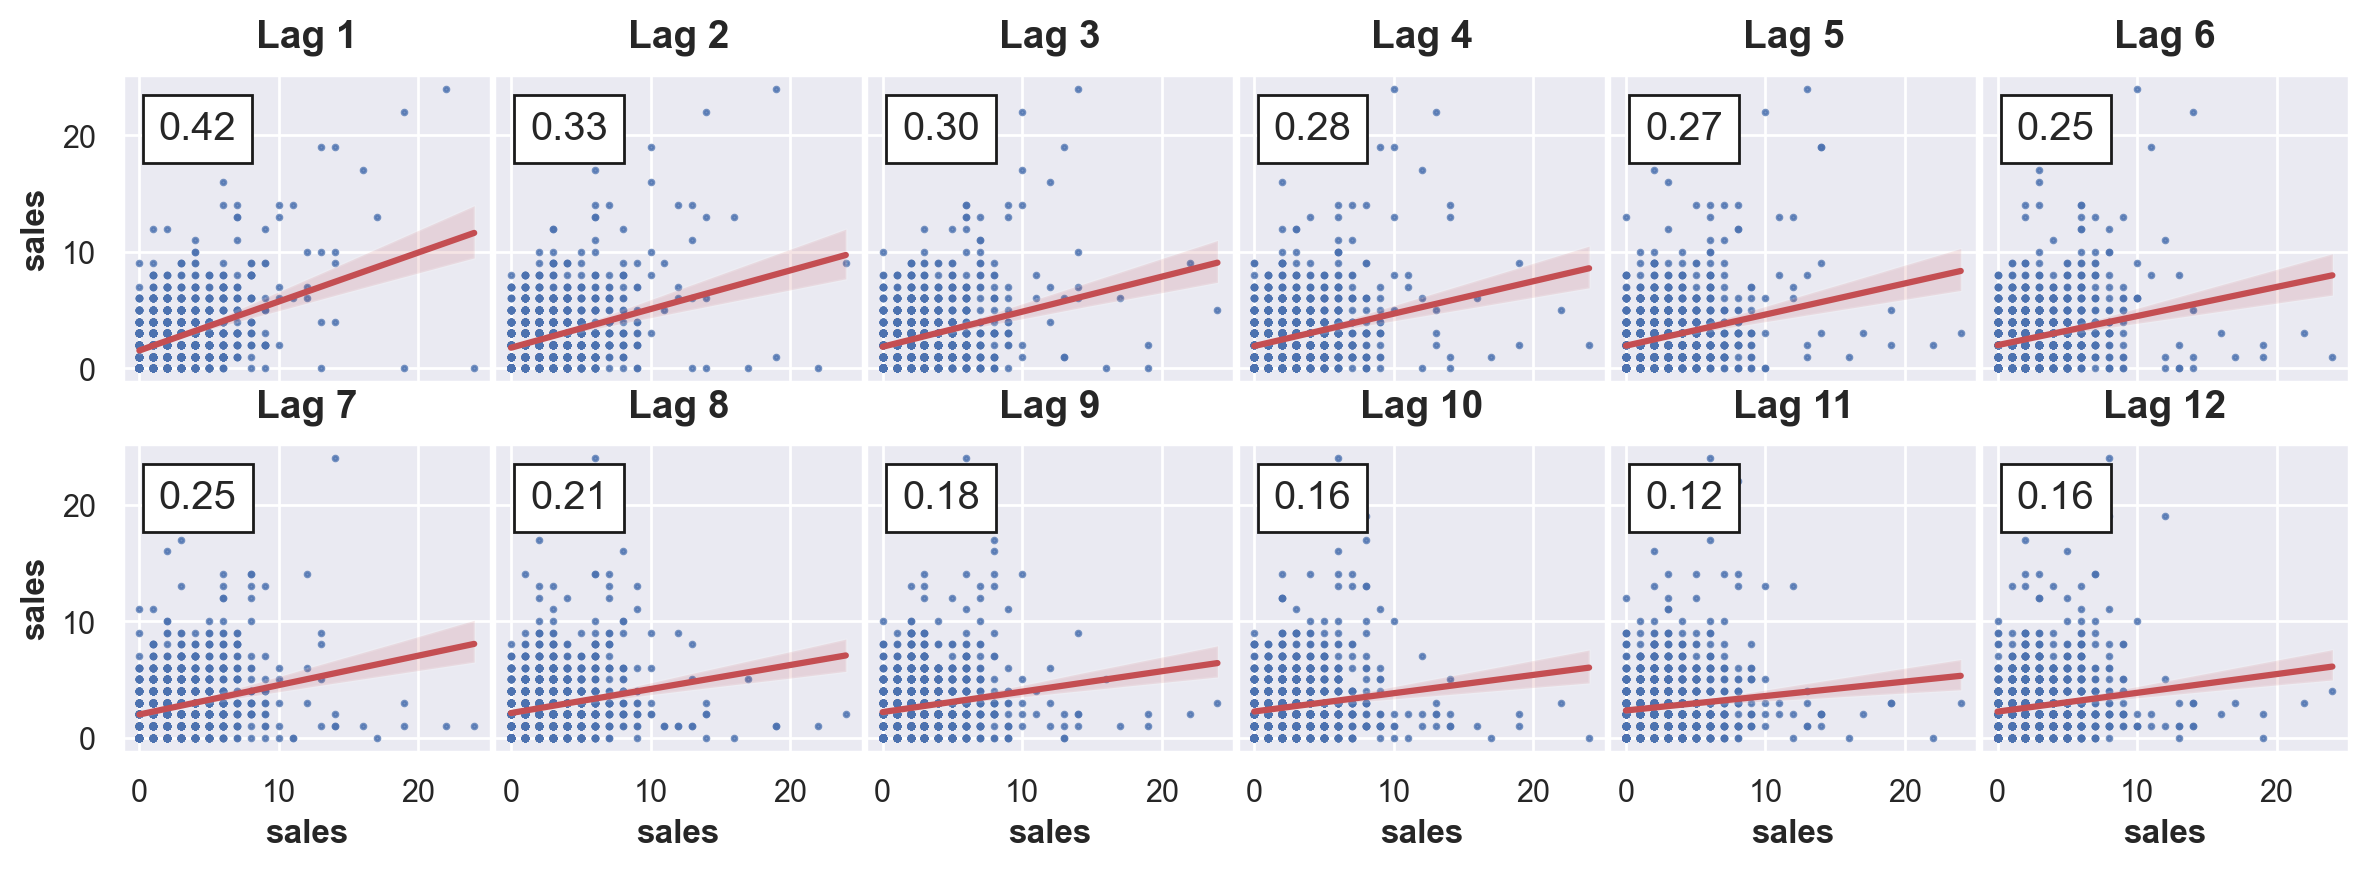

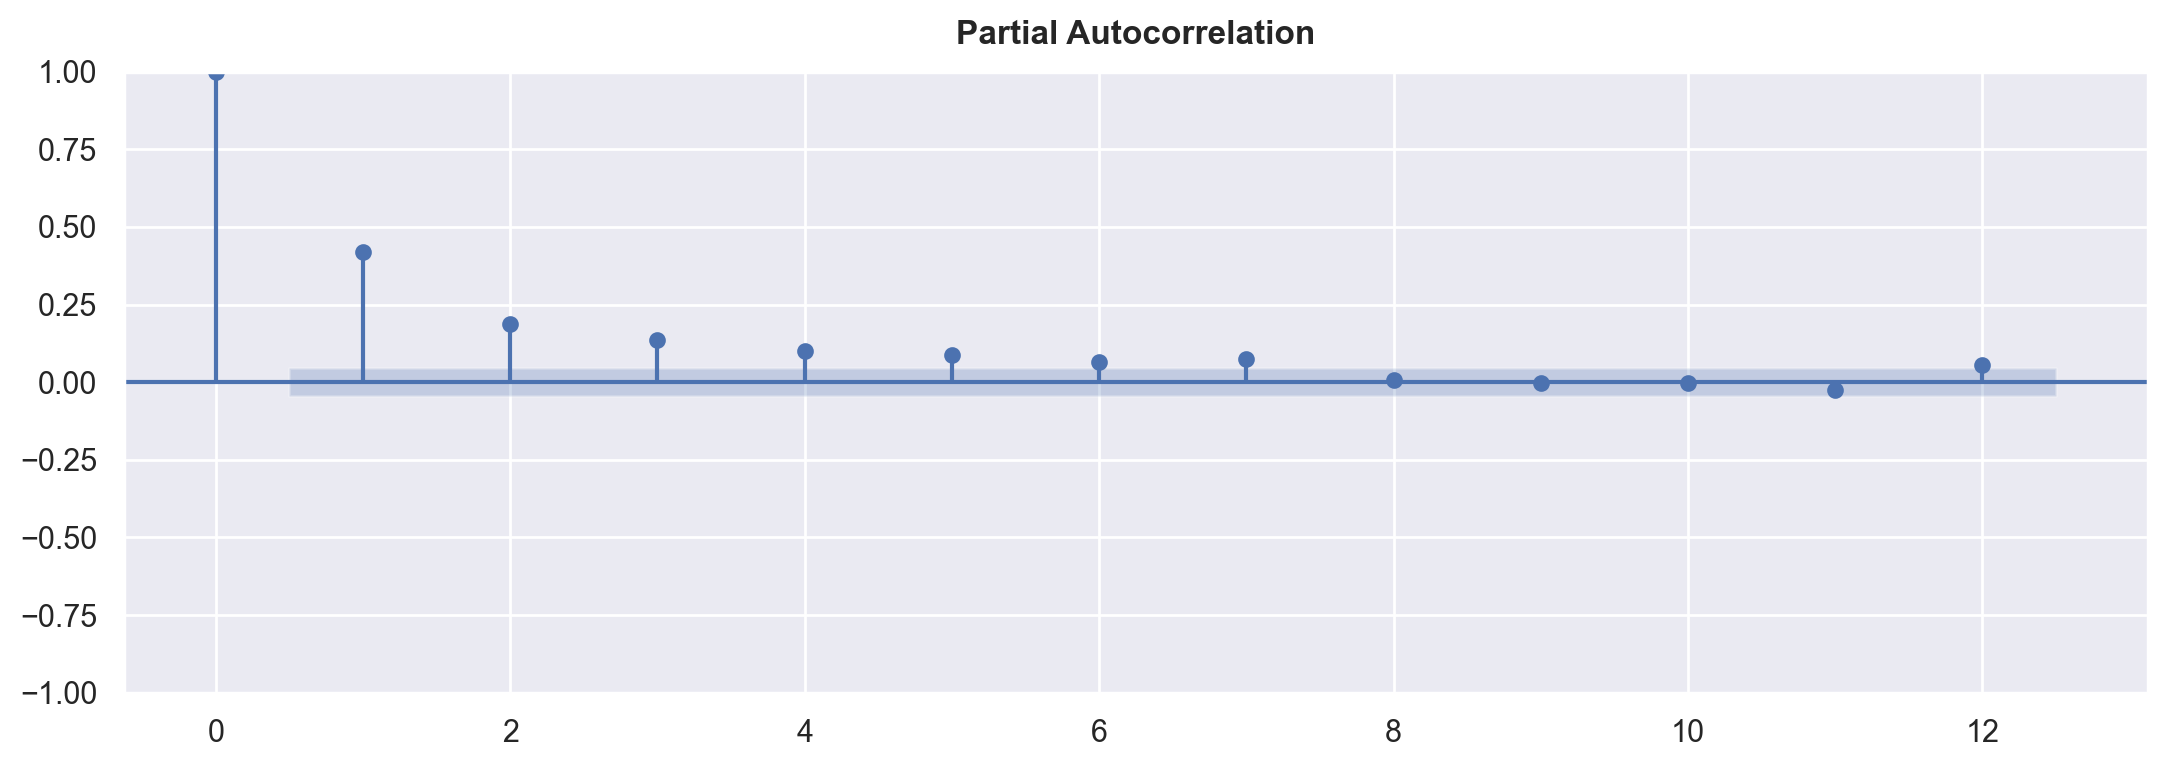

In [376]:
ax = merged_all_sales.sales.plot(title='Sales Trend', **plot_params)
_ = ax.set(ylabel="Sales")

_ = plot_lags(merged_all_sales.sales, lags=12, nrows=2)
_ = plot_pacf(merged_all_sales.sales, lags=12)

In [377]:
X = make_lags(merged_all_sales.sales, lags=8)
X = X.fillna(0.0)

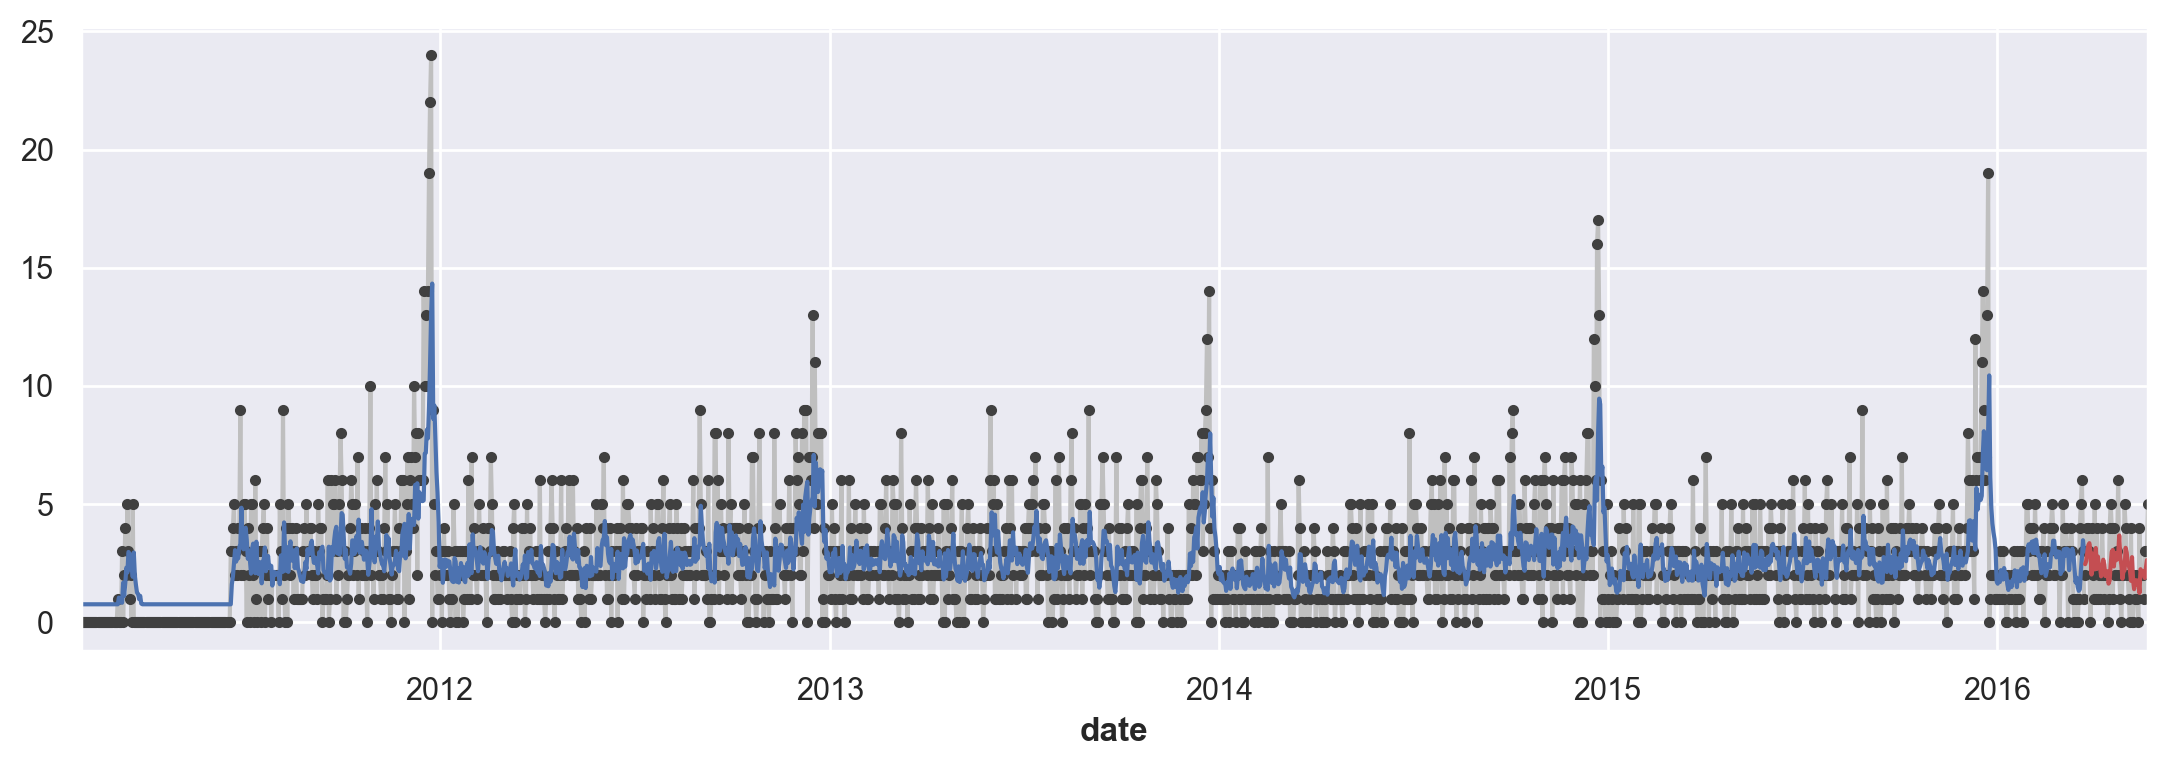

In [381]:
from sklearn.model_selection import train_test_split
# Create target series and data splits
y = merged_all_sales.sales.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

#ax = y_train[-100:].plot(**plot_params)
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
#ax = y_pred[-100:].plot(ax=ax)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')

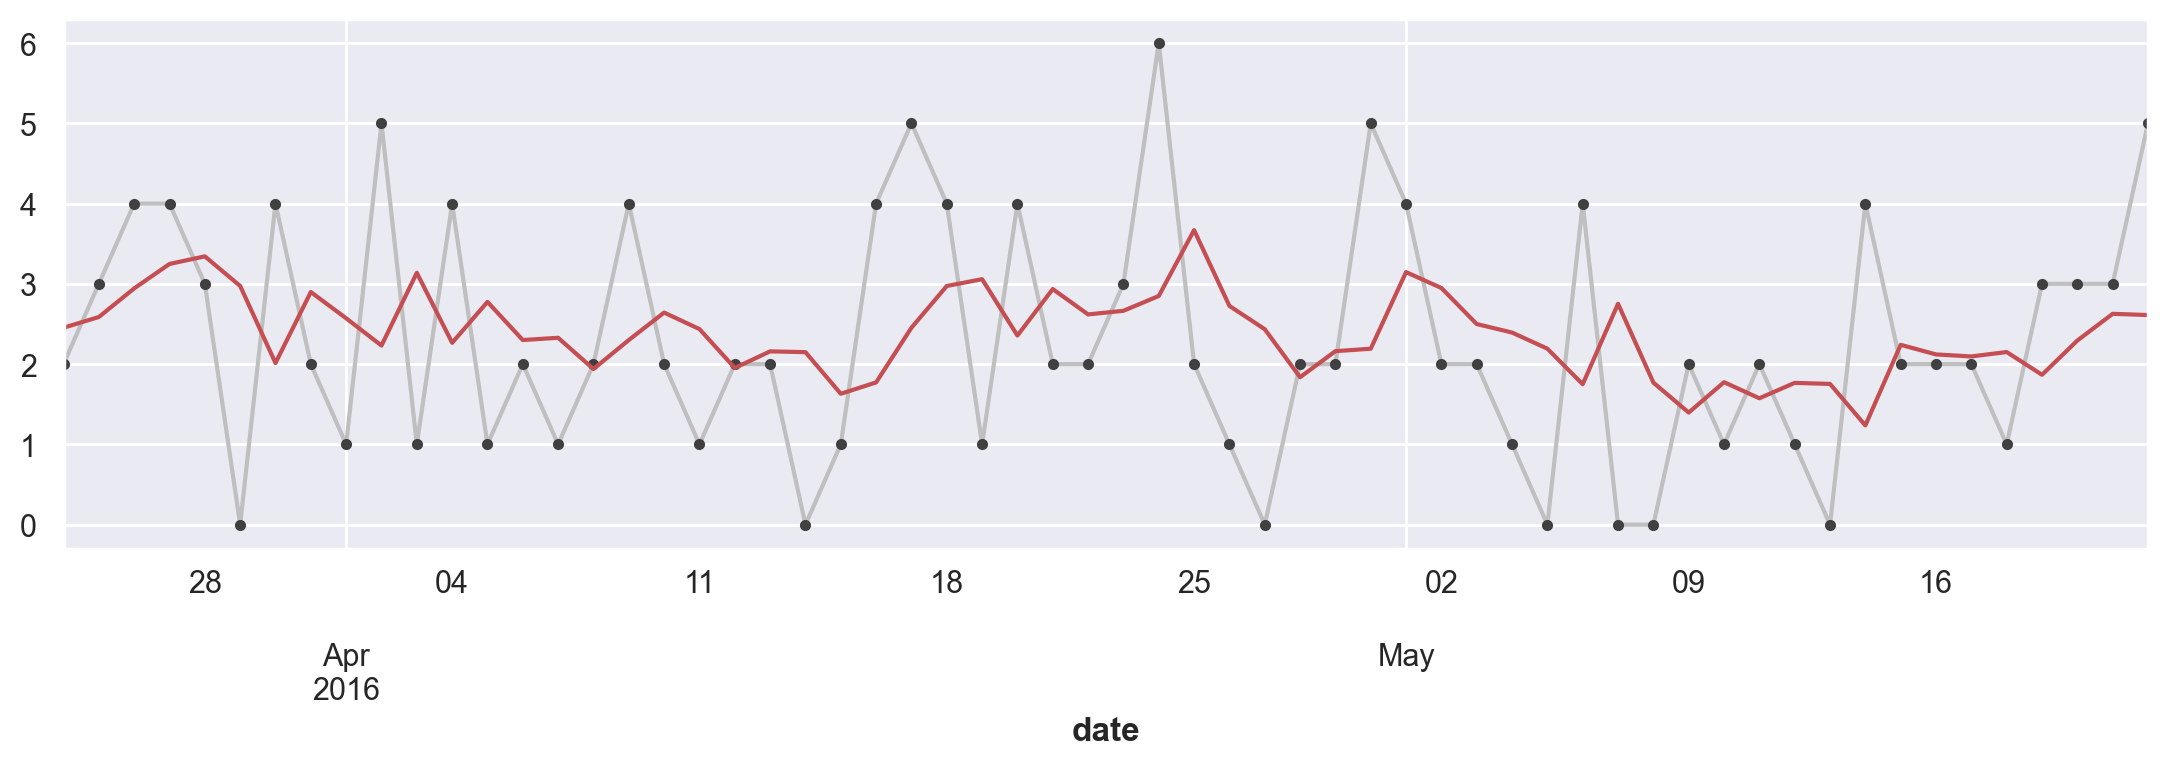

In [382]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

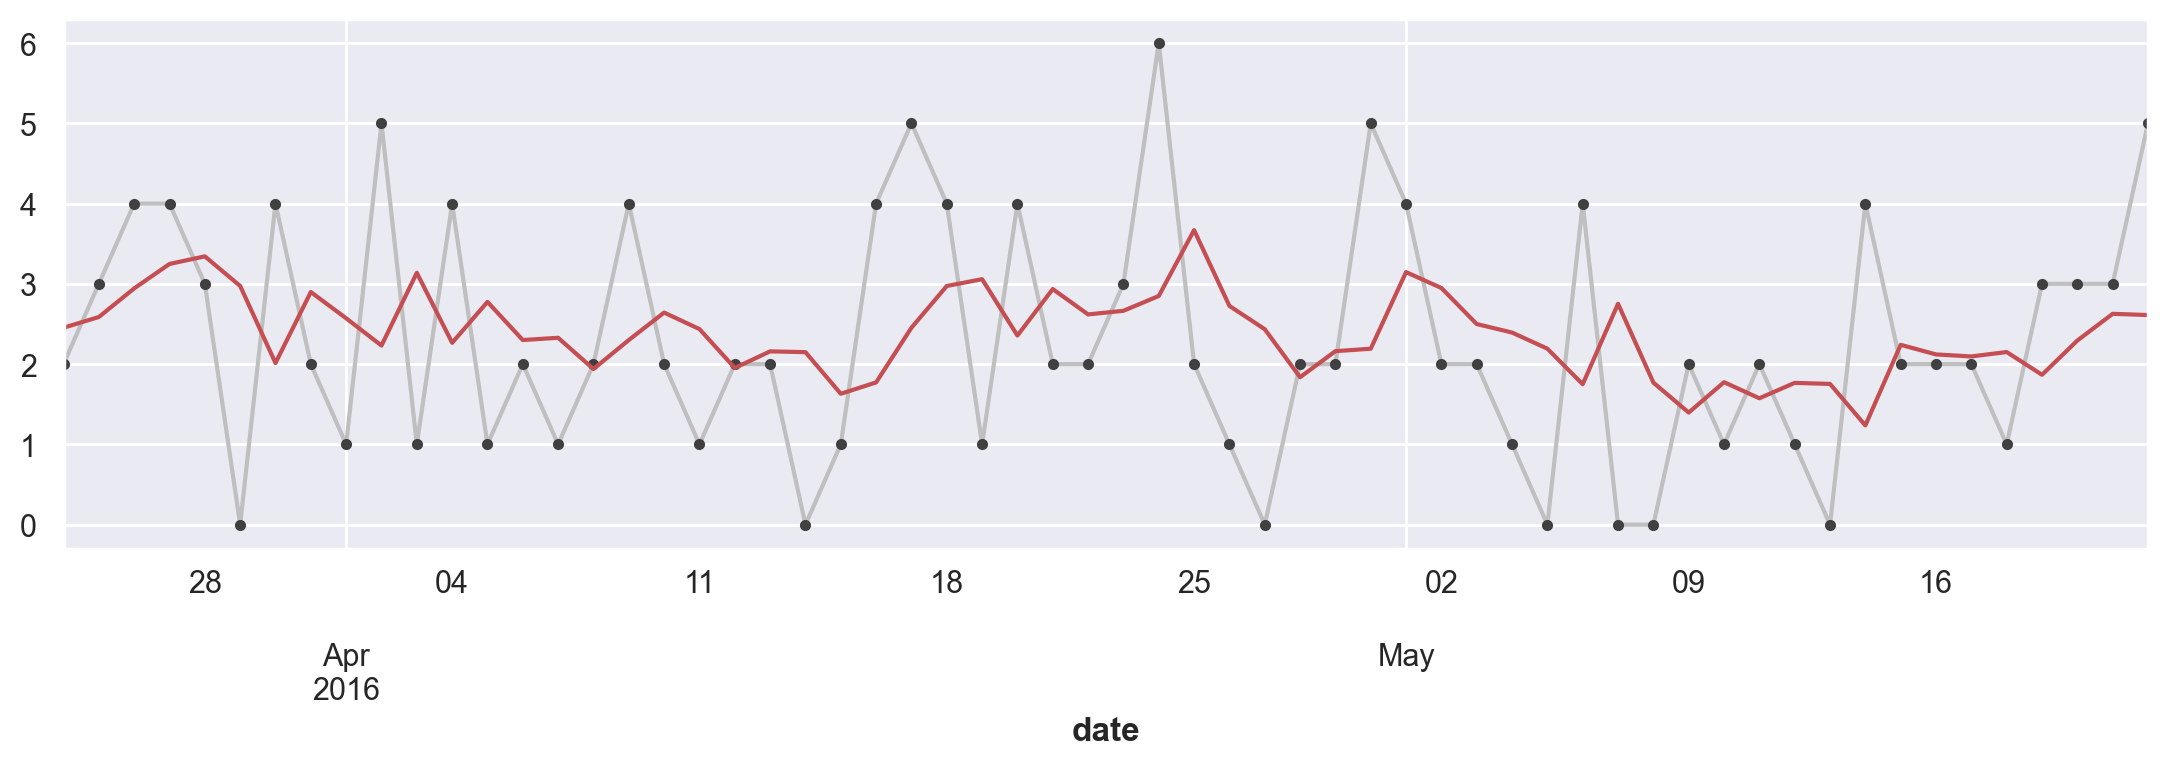

In [383]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')